***
# Constants and functions
***

This notebook contains the analysis for the measurement of the transverse intrinsic coherence width of the neutron at the LARMOR beamline at ISIS. The experiment was performed in SESANS mode in February 2023. The sample used was a 2 micron period silicon grating in transmission mode. Our results show no dependence of the scattering profile on the coherence width of the neutron, which is supported by a theorectical 2-path interferometric model.

In [2]:
import numpy as np
from scipy.signal import *
from scipy.fft import *
from scipy.integrate import simpson
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import diric
import csv

np.set_printoptions(suppress=True)

SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 30

plt.rcParams['figure.figsize'] = (10,6.1803)
plt.rc('lines', linewidth=3)

if True: #Additions to latex preamble for matplotlib:
    plt.rc('text', usetex=True)
    plt.rc('text.latex', preamble=r'\usepackage{textcomp,amsmath,amsthm,amssymb,amsfonts,braket,siunitx,upgreek}')
    plt.rcParams["font.family"] = "Computer Modern Roman"

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def splitter(x,lim):
    """Splits data into peaks. x is the list of points above some thresold."""
    N = 1  #number of splits
    diffs = np.diff(x)
    for i in diffs:
        if i>lim: N += 1
    temp = [[] for n in range(N)]
    
    tempN = 0
    for i in range(len(x)-1):
        if diffs[i]<=lim:
            temp[tempN].append(x[i])
        else:
            temp[tempN].append(x[i])
            tempN += 1
    filtered = temp.copy()
    for i in temp:
        if len(i) <= 3: filtered.remove(i)
    return filtered

def ampgauss(x,amp,a,s):
    return amp*np.exp(-(x-a)**2/2/s**2)

def gauss(x,a,s):
    return 1/(np.sqrt(2*np.pi)*s)*np.exp(-(x-a)**2/2/s**2)

def cos(x,a,f,s):
    return s+a*np.cos(x*f)

def BG(x,a,f):
    return 1+a*(np.cos(np.sqrt(x)*f)-1)

def BG_2(x,f):
    return 2/f**2*(1-np.cos(np.sqrt(x)*f))/x

def line(x,a,b):
    return a*x+b

def quad(x,a,b):
    return 1-a*x**2-b*x

G = -1.832471e8    #gyromagnetic ratio of neutron (rad/T/m^2)
M = 1.674927e-27    #mass of neutron (kg)
HBAR = 1.054571e-34    #plancks constant (kg m^2/s)
H = HBAR*2*np.pi
CL = G/(HBAR*2*np.pi)*M    #Larmor phase constant (T^-1 m^-1 AA^-1)

def get_BG_freq(temp_freq,deg,p=True):
    spc = 2*1.67e-27*temp_freq*1e6*1.2/6.626e-34/np.tan(deg/180*np.pi)*1e-10 #per Angstrom
    global sld 
    sld = 2.06e-6  #per Angstrom squared
    global d 
    d = 10.5*1e4  #groove depth in Angstroms
    tc = sld*d/np.sqrt(spc)  #'that constant'
    if p:
        print(f'a = {round(spc)} A^-1 at rf freq {temp_freq} MHz')
        print(f'Cosine freq {round(tc*1e2,5)} um^(-1/2) \n')
    return spc,tc

a_2MHz,_ = get_BG_freq(2,40)
a_3MHz,_ = get_BG_freq(3,40)

home_path = "C:\\Users\\samck\\Documents\\GitHub\\SESANS-coherence-length\\Processed data\\"
work_path = "C:\\Users\\xsm\\Documents\\GitHub\\SESANS-coherence-length\\Processed data\\"

rob_2MHz = 1e4*np.polyval([7.42468285310946e-09, -2.37424465512104e-6, 2.92814364848172e-04,
                       -1.85712645099827e-02, 5.44463590018381e-01], 40.)
rob_3MHz = rob_2MHz*1.5

print(f'Rob\'s 2MHz calibration: a = {round(rob_2MHz)} A^-1')
print(f'Cosine freq {round(Rob_2 := sld*d/np.sqrt(rob_2MHz)*1e2,5)} um^(-1/2) \n')
print(f'Rob\'s 3MHz calibration: a = {round(rob_3MHz)} A^-1')
print(f'Cosine freq {round(Rob_3 := sld*d/np.sqrt(rob_3MHz)*1e2,5)} um^(-1/2) \n')

a = 1442 A^-1 at rf freq 2 MHz
Cosine freq 0.56965 um^(-1/2) 

a = 2163 A^-1 at rf freq 3 MHz
Cosine freq 0.46512 um^(-1/2) 

Rob's 2MHz calibration: a = 1372 A^-1
Cosine freq 0.58402 um^(-1/2) 

Rob's 3MHz calibration: a = 2058 A^-1
Cosine freq 0.47685 um^(-1/2) 



## Moderator contribution

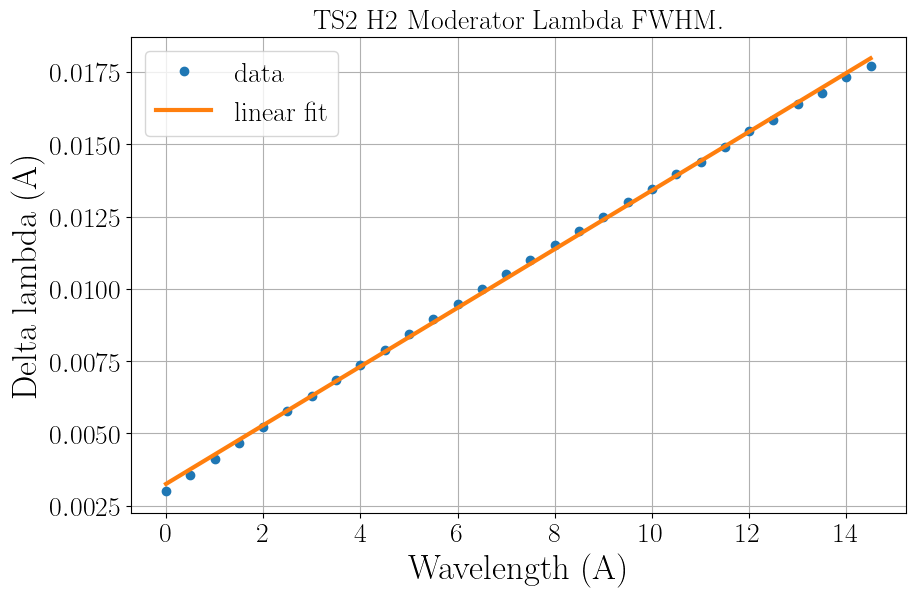

y = Ax + B: [A,B]=[0.00101487 0.0032538 ]
Error: [0.00000523 0.00004413]


In [4]:
mpath = "C:\\Users\\xsm\\Documents\\GitHub\\SESANS-coherence-length\\Reduction\\"
mmod = "ModeratorStdDev_TS2_SANS_LETexptl_07Aug2015.txt"

with open(mpath+mmod) as file:
    lines = csv.reader(file, delimiter='\t')
    x,y = [],[]
    for row in lines:
        x.append(float(row[0]))
        y.append(float(row[1]))
    x,y = np.copy(x)[:len(x)//2],np.copy(y)[:len(x)//2]

dl = H/M/29.7*y*1e10*1e-6  #check this with Rob

plt.title('TS2 H2 Moderator Lambda FWHM.')
plt.plot(x,dl,'o',label='data')
mlin,mlinerr = curve_fit(line,x,dl)
plt.plot(x,line(x,*mlin),label='linear fit')
plt.xlabel('Wavelength (A)')
plt.ylabel('Delta lambda (A)')
plt.legend()
plt.grid()
plt.show()

Amod,Bmod = mlin  #storing the fit
print(f'y = Ax + B: [A,B]={mlin}')
print(f'Error: {np.sqrt(np.diag(mlinerr))}')

## Instrumental resolution

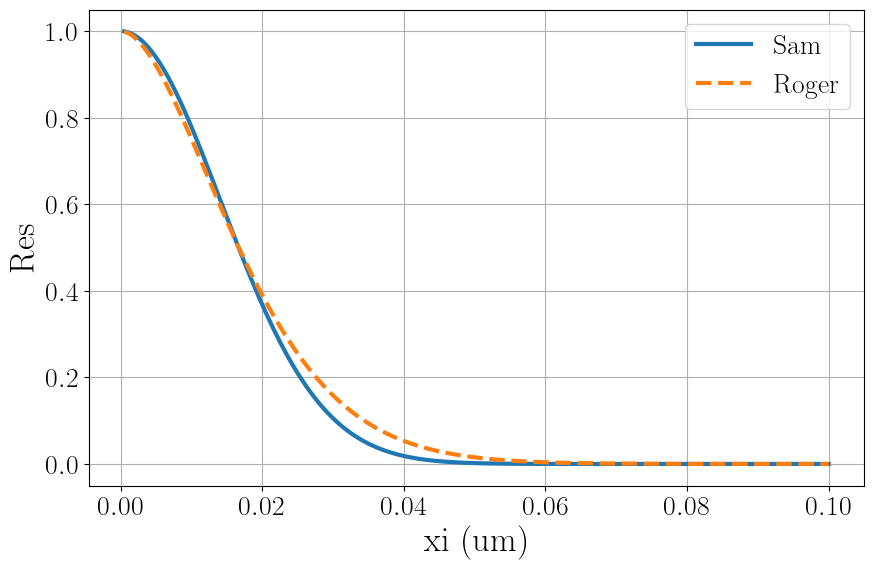

In [42]:
xi_space = np.linspace(0,.1,200)[1:]  #microns
T0 = 40*np.pi/180.
DTHETA = (14+5)/2*1e-3/5/2/np.sqrt(6)  #uniform divergence standard deviation
JIT = 10*1e-3  #grating jitter
E = .01  #binning error
spe = a_2MHz*1e4

def get_res(xi,dtheta=DTHETA,theta_0=T0,jit=JIT,al=Amod*1e-4,bl=Bmod,bin_err=E):
    """Calculates the SESANS resolution function."""
    #dxi2 = (2*dtheta/np.sin(2*theta_0))**2*(xi/spe)**2 + jit**2 + 4*bin_err**2 + (4*bl**2 + 8*al*bl/np.sqrt(xi/spe) + 4*al**2/(xi/spe))*(xi/spe)**2
    #return np.exp(-xi**2/2/dxi2),dxi2
    dxi_xi2 = (2*dtheta/np.sin(2*theta_0))**2 + 4*(al + bl*np.sqrt(xi/spe))**2/(xi/spe) + (jit/xi)**2 + (bin_err/xi)**2
    return np.exp(-1/(2*dxi_xi2)),dxi_xi2

R,dxi = get_res(xi_space)

roger_dxi = xi_space*(.0035+.086/np.sqrt(xi_space*1000/137.17))+.01
#roger_dxi = (0.0000101687*xi_space**(3/2) + 6.5764e-6*xi_space**2 + 0.000120283*xi_space + 0.0001)*1e3

Roger = np.exp(-1/2*(xi_space/roger_dxi)**2)

plt.plot(xi_space,R,label='Sam')
plt.plot(xi_space,Roger,'--',label='Roger')
plt.ylabel('Res')
plt.xlabel('xi (um)')
#plt.plot(ftR,label='FFT Res')
plt.legend()
plt.grid()
plt.show()

***
# 90 deg data 2MHz
***

a = 1442 A^-1 at rf freq 2 MHz
Cosine freq 0.56965 um^(-1/2) 



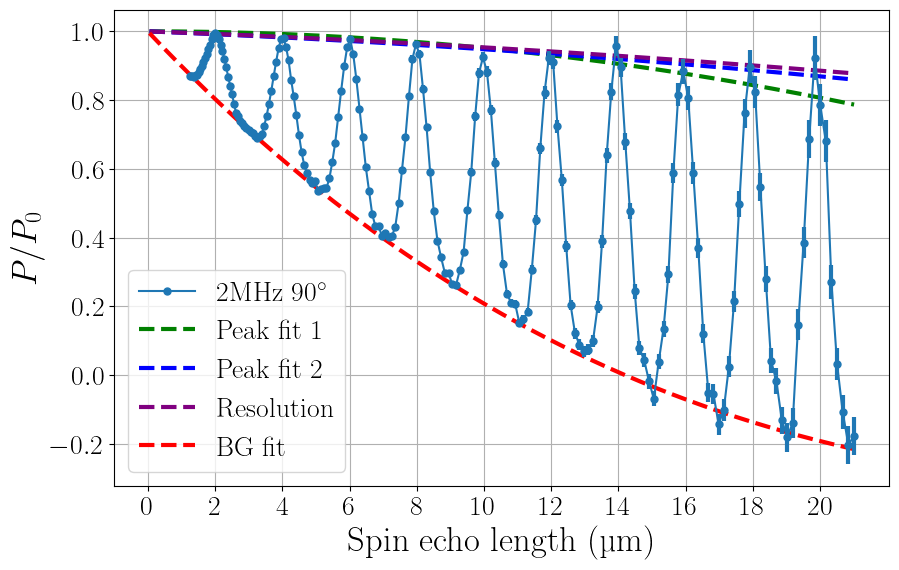

BG fit: 1 + amp*(cos(sqrt(freq)) - 1), [amp,freq]=[0.66062 0.55994]
	 Errs: [0.02696 0.01432]
Peak fit: 1-A*x^2: [0.0004827]
	 Err: [0.0000798]
Peak fit: 1-A*x^2-B*x: [A,B]=[0.0001338 0.0038694]
	 Err: [0.0001035 0.0010041]
FWHM (no linear term): 53.59 um
FWHM: 101.79 um


In [15]:
path = work_path #home_path
file = "pols_2Mhz_90deg3.0_0.05_12.5.dat"

with open(path+file) as f:
    temp = f.readlines()[2:-2]  #-2 to include last peak, -26 otherwise
    temp = [l.replace('\n','').split(',') for l in temp]
    x = np.array([float(temp[x][0]) for x in range(len(temp))])/1e3
    x_tot = np.linspace(x[-1],0,400,endpoint=False)[::-1]
    y = np.array([float(temp[y][1]) for y in range(len(temp))])
    e = np.array([float(temp[y][2]) for y in range(len(temp))])
    
    tr,_ = find_peaks(-y,prominence=.1)  #finding the troughs
    tr = np.insert(tr,[0],[0])  #insert first point: P(0)=1
    pk,_ = find_peaks(y,prominence=.1)  #finding the autocorrelation peaks
    
fig, ax = plt.subplots()
plt.plot(x,y,'o',label='2MHz 90$^{\circ}$',color='C0',ms=5,zorder=5,ls='-',linewidth=1.5)
plt.errorbar(x,y,e,color='C0',ls='none',zorder=5)

#plt.plot(x[pk],y[pk],'o',ms=10,color='green',zorder=10)
guess_pk = [0,0]
parms_pk1,err_pk1 = curve_fit(lambda x,a: quad(x,a,0),x[pk],y[pk],sigma=e[pk])  #no linear term
plt.plot(x_tot,quad(x_tot,*parms_pk1,0),'--',color='green',label='Peak fit 1')
parms_pk2,err_pk2 = curve_fit(quad,x[pk],y[pk],sigma=e[pk])
plt.plot(x_tot,quad(x_tot,*parms_pk2),'--',color='blue',label='Peak fit 2')

res_coeff = [1.,-.0036,-.000106]  #coefficients from Roger
res = np.sum([res_coeff[i]*x**i for i in range(len(res_coeff))],axis=0)
res_fine = np.sum([res_coeff[i]*x_tot**i for i in range(len(res_coeff))],axis=0)
plt.plot(x_tot,res_fine,'--',color='purple',label='Resolution')

#plt.plot(x[tr],y[tr],'o',ms=10,color='red',zorder=10)
guess_tr = [.65,get_BG_freq(2,40)[1]]
parms_tr,err_tr = curve_fit(BG,x[tr],y[tr],p0=guess_tr,sigma=e[tr])
plt.plot(x_tot,BG(x_tot,*parms_tr),'--',color='red',label='BG fit')

ax.legend(loc='lower left')
plt.xlabel(r'Spin echo length (\textmu m)')
plt.ylabel(r'$P/P_0$')
ax.set_xticks(range(0,21,2))
plt.grid()
plt.show()

print(f'BG fit: 1 + amp*(cos(sqrt(freq)) - 1), [amp,freq]={np.round(parms_tr,5)}')
print(f'\t Errs: {np.round(np.sqrt(np.diag(err_tr)),5)}')
print(f'Peak fit: 1-A*x^2: {np.round(parms_pk1,7)}')  #ignoring linear term
print(f'\t Err: {np.round(np.sqrt(np.diag(err_pk1)),7)}')
print(f'Peak fit: 1-A*x^2-B*x: [A,B]={np.round(parms_pk2,7)}')
print(f'\t Err: {np.round(np.sqrt(np.diag(err_pk2)),7)}')

FWHM_2MHz_90_1 = np.sqrt(2*np.log(2)/parms_pk1[0])
print(f'FWHM (no linear term): {round(FWHM_2MHz_90_1,2)} um')
FWHM_2MHz_90_2 = np.sqrt(2*np.log(2)/parms_pk2[0])
print(f'FWHM: {round(FWHM_2MHz_90_2,2)} um')

BG_parms_2_90 = parms_tr  #save parameters for later comparison
BG_err_2_90 = err_tr
X_2MHz_90 = np.copy(x)
X_tot_2MHz_90 = np.copy(x_tot)
Y_2MHz_90 = np.copy(y)
E_2MHz_90 = np.copy(e)
Peaks_2MHz_90 = np.copy(pk)

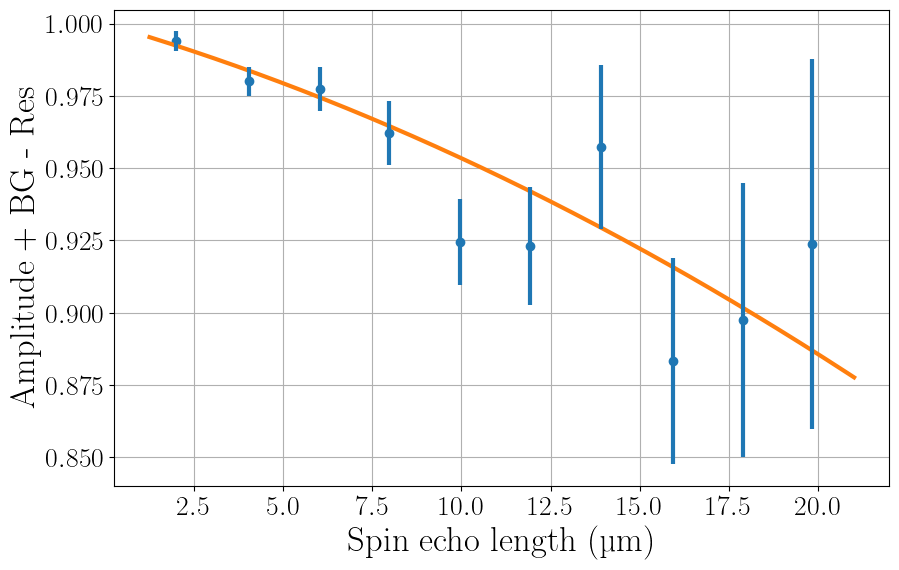

In [3]:
subtracted = Y_2MHz_90-BG(x,*BG_parms_2_90)
peak_x = np.where(subtracted>0.05)
seperated = splitter(peak_x[0],1)
fparms,errs = [],[]

plot_peaks,plot_res = False,True

fig, ax = plt.subplots()
plt.plot(x,subtracted,'--',color='black')
for indx,sep in enumerate(seperated):
    plt.plot(x[sep],np.zeros(len(sep)),'o',color='black',zorder=10)  #peak fit domain
    
    guess = [.5,x[sep[len(sep)//2]],.4]
    ff,err = curve_fit(ampgauss,x[sep],subtracted[sep],p0=guess)
    fparms.append(ff)
    errs.append(err)
    #plt.plot(x,ampgauss(x,*guess),'--',color=f'C{indx}')
    plt.plot(x,ampgauss(x,*ff),color=f'C{indx}')
    #print(f'Fitted peak {indx}: [amp,av,sig]={np.round(ff,3)}')
    #print(f'\t Errors: {np.round(np.sqrt(np.diag(err)),5)}')
plt.xlabel(r'Spin echo length (\textmu m)')
plt.ylabel(r'$P/P_0$')
plt.grid()
if plot_peaks: plt.show()
else: plt.close()

fparms = np.array(fparms)
order_errs = np.array([np.sqrt(np.diag(i)) for i in errs])  #peak order errors
x_indx = [np.argmin(np.abs(x-fparms[i,1])) for i in range(len(fparms[:,0]))]

fig, ax = plt.subplots()
"""plt.plot(fparms_2MHz_90[:,1],fparms_2MHz_90[:,0]+BG(fparms_2MHz_90[:,1],*BG_parms_2_90),'o')
plt.errorbar(fparms_2MHz_90[:,1],fparms_2MHz_90[:,0]+BG(fparms_2MHz_90[:,1],*BG_parms_2_90),\
             order_errs[:,0],ls='none',color='C0',zorder=5)"""
plt.plot(X_2MHz_90[Peaks_2MHz_90],Y_2MHz_90[Peaks_2MHz_90],'o')
plt.errorbar(X_2MHz_90[Peaks_2MHz_90],Y_2MHz_90[Peaks_2MHz_90],E_2MHz_90[Peaks_2MHz_90],ls='none',color='C0',zorder=5)
plt.plot(X_2MHz_90,res)
plt.xlabel(r'Spin echo length (\textmu m)')
plt.ylabel(r'Amplitude + BG - Res')
plt.grid()
if plot_res: plt.show()
else: plt.close()

fparms_2MHz_90 = np.copy(fparms)  #save parameters for later comparison
errs_2MHz_90 = np.copy(order_errs)

***
# 8 deg data 2 MHz
***

a = 1442 A^-1 at rf freq 2 MHz
Cosine freq 0.56965 um^(-1/2) 



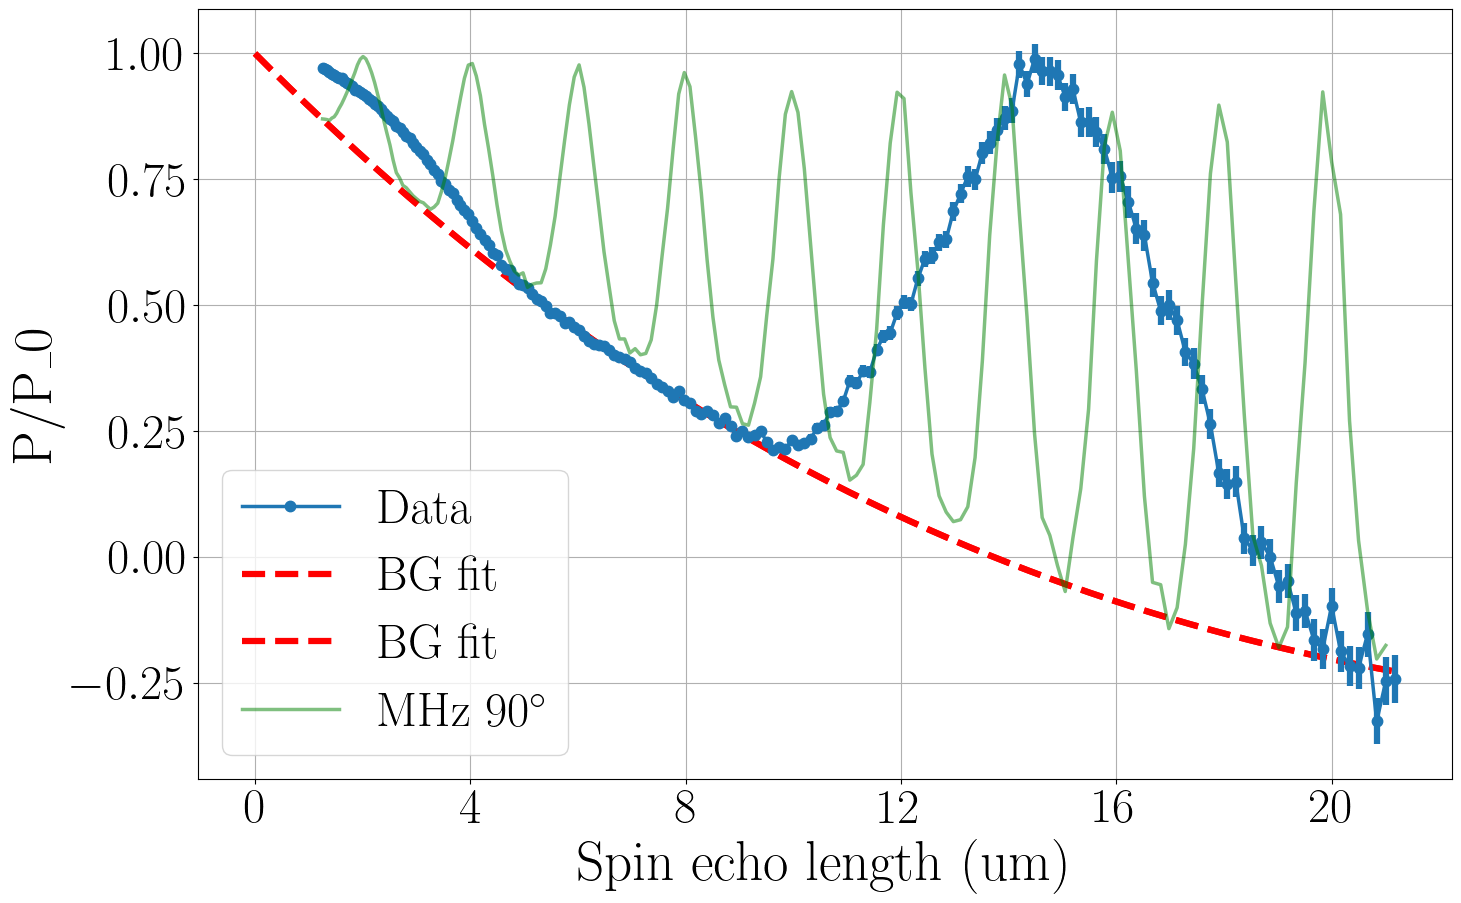

2MHz, 90deg background: [amp,freq]=[0.6606 0.5599]
New Background: [amp,freq]=[0.6525 0.5756]
--------------------------------------------------

Fitted peak 0: [amp,av,sig]=[0.127 2.246 1.464]
	 Errors: [0.00041 0.00897 0.01418]
Fitted peak 1: [amp,av,sig]=[ 0.988 14.864  2.116]
	 Errors: [0.00592 0.0146  0.01515]


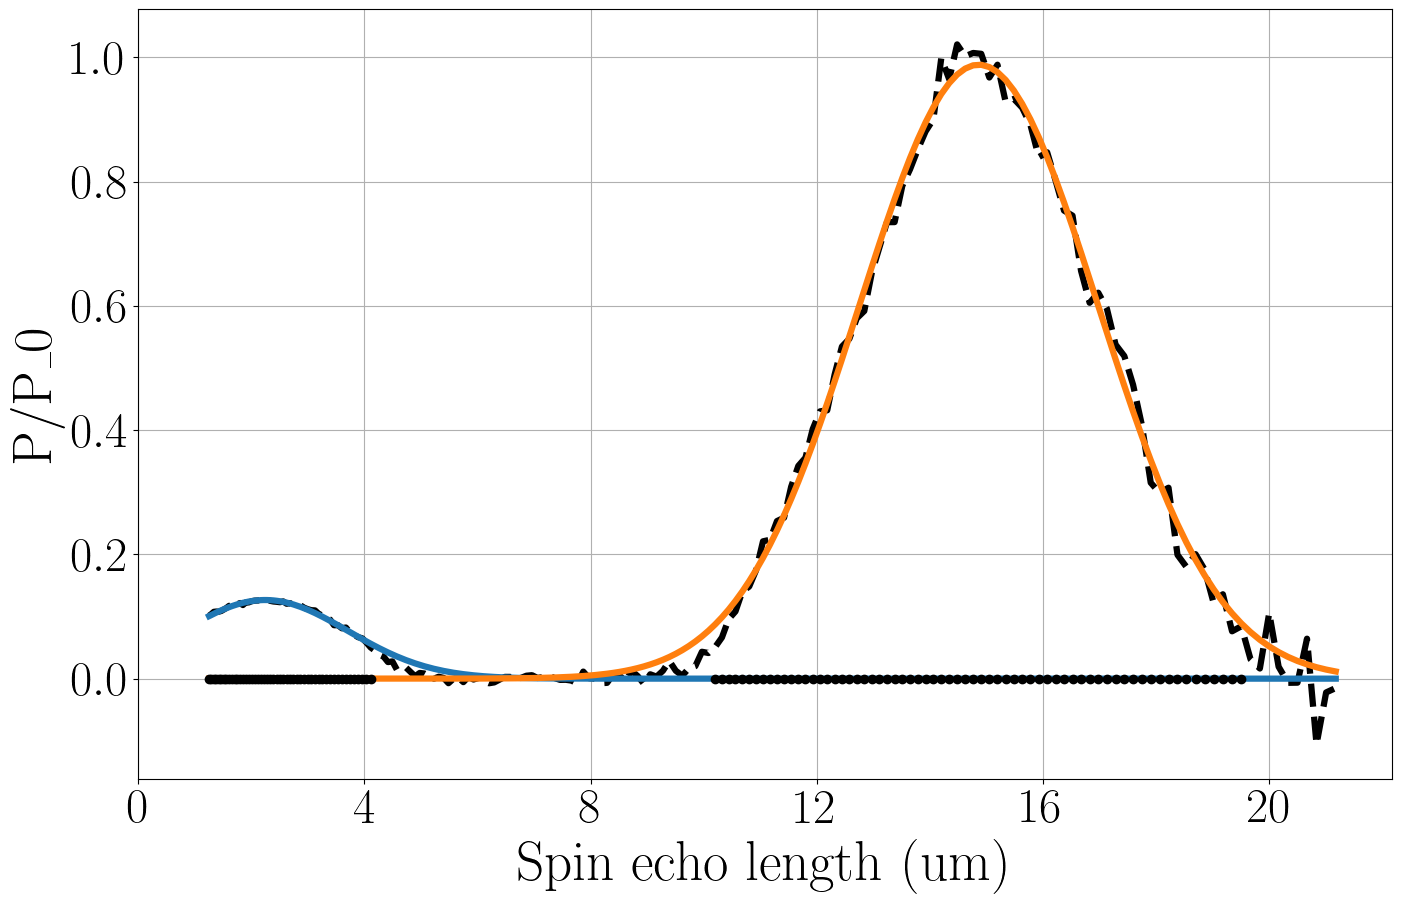

In [4]:
path = home_path
file = "pols_2Mhz_8deg3.0_0.05_12.5.dat"

with open(path+file) as f:
    temp = f.readlines()[2:-1]
    temp = [l.replace('\n','').split(',') for l in temp]
    x = np.array([float(temp[x][0]) for x in range(len(temp))])/1e3
    x_tot = np.linspace(0,x[-1],400)
    y = np.array([float(temp[y][1]) for y in range(len(temp))])
    e = np.array([float(temp[y][2]) for y in range(len(temp))])
    
fig, ax = plt.subplots()
plt.plot(x,y,'o',label='Data',color='C0',ms=7.5,zorder=5,ls='-',linewidth=2.5)
plt.errorbar(x,y,e,color='C0',ls='none',zorder=5)

if False:
    bg_sec = np.where((5.25<x) & (x<9.25))[0]  #too large for large spin echo lengths
    bg_p,_ = curve_fit(BG,x[bg_sec],y[bg_sec],p0=bg_guess,sigma=e[bg_sec])
    plt.plot(x_tot,BG(x_tot,*bg_p),'--',color='magenta',label='BG fit 2')

bg_sec = np.where((5.25<x) & (x<9.25) | (x>20.2))[0]
bg_guess = [.65,get_BG_freq(2,40)[1]]
bg_p,_ = curve_fit(BG,x[bg_sec],y[bg_sec],p0=bg_guess,sigma=e[bg_sec])
plt.plot(x_tot,BG(x_tot,*bg_p),'--',color='red',label='BG fit')
#plt.plot(X_tot_saved,BG(X_tot_saved,*BG_parms_2_90),'--',color='green',label='BG (90$^{\circ}$)')

plt.plot(x_tot,BG(x_tot,*bg_p),'--',color='red',label='BG fit')

plt.plot(X_saved,Y_saved,color='green',label='MHz 90$^{\circ}$',alpha=.5,ms=7.5,zorder=5,ls='-',linewidth=2.5)

plt.xlabel('Spin echo length (um)')
plt.ylabel('P/P_0')
ax.set_xticks(range(0,21,4))
plt.grid()
ax.legend()
plt.show()

BG_parms_2_8 = bg_p  #save background parameters for later
subtracted = y-BG(x,*BG_parms_2_8)
peak_x = np.where(abs(subtracted)>0.05)

print(f'2MHz, 90deg background: [amp,freq]={np.round(parms_tr,4)}')
print(f'New Background: [amp,freq]={np.round(BG_parms_2_8,4)}')
print('-'*50 + '\n')

#Symmetric peak fitting
fig, ax = plt.subplots()
plt.plot(x,subtracted,'--',color='black')

seperated = splitter(peak_x[0],1)
fparms = []

for indx,sep in enumerate(seperated):
    plt.plot(x[sep],np.zeros(len(sep)),'o',color='black',zorder=10)  #peak fit domain
    
    guess = [.5,x[sep[len(sep)//2]],3]
    ff,errs = curve_fit(ampgauss,x[sep],subtracted[sep],p0=guess)
    fparms.append(ff)
    #plt.plot(x,ampgauss(x,*guess),'--',color=f'C{indx}')
    plt.plot(x,ampgauss(x,*ff),color=f'C{indx}')
    print(f'Fitted peak {indx}: [amp,av,sig]={np.round(ff,3)}')
    print(f'\t Errors: {np.round(np.sqrt(np.diag(errs)),5)}')
fparms = np.array(fparms)

plt.xlabel('Spin echo length (um)')
plt.ylabel('P/P_0')
ax.set_xticks(range(0,21,4))
plt.grid()
plt.show()

X2_saved = np.copy(x)
X2_tot_saved = np.copy(x_tot)
fparms2_saved = np.copy(fparms)
Y2_saved = np.copy(y)
E2_saved = np.copy(e)
BG_parms_2_8 = bg_p

In [ ]:
if False:
    #Asymmetric peak fitting, doesn't seem to work well
    fig, ax = plt.subplots()
    plt.xlabel('Spin echo length (um)')
    plt.ylabel('P/P_0')
    ax.set_xticks(range(0,21,2))
    plt.grid()

    plt.plot(x,subtracted,'--',color='black')
    #uses same peaks found in symmetric fitting section

    fparms = []
    for indx,sep in enumerate(seperated):
        plt.plot(x[sep],np.zeros(len(sep)),'o',color='black',zorder=10)  #peak fit domain
    
        guess = [1,x[sep[indx]],3,-1]
        ffa,aerrs = curve_fit(asyg,x[sep],subtracted[sep],p0=guess)
        #plt.plot(x,asyg(x,*guess),'--',color=f'C{indx}')
        plt.plot(x,asyg(x,*ffa),color=f'C{indx}')
    
        print(f'Fitted peak {indx}: [amp,av,sig,a]={np.round(ffa,3)}')
        print(f'\t Errors: {np.round(np.sqrt(np.diag(aerrs)),5)}')
    
    plt.show()

***
# 8deg data 3 MHz
***

New BG function: [0.69    0.45719]


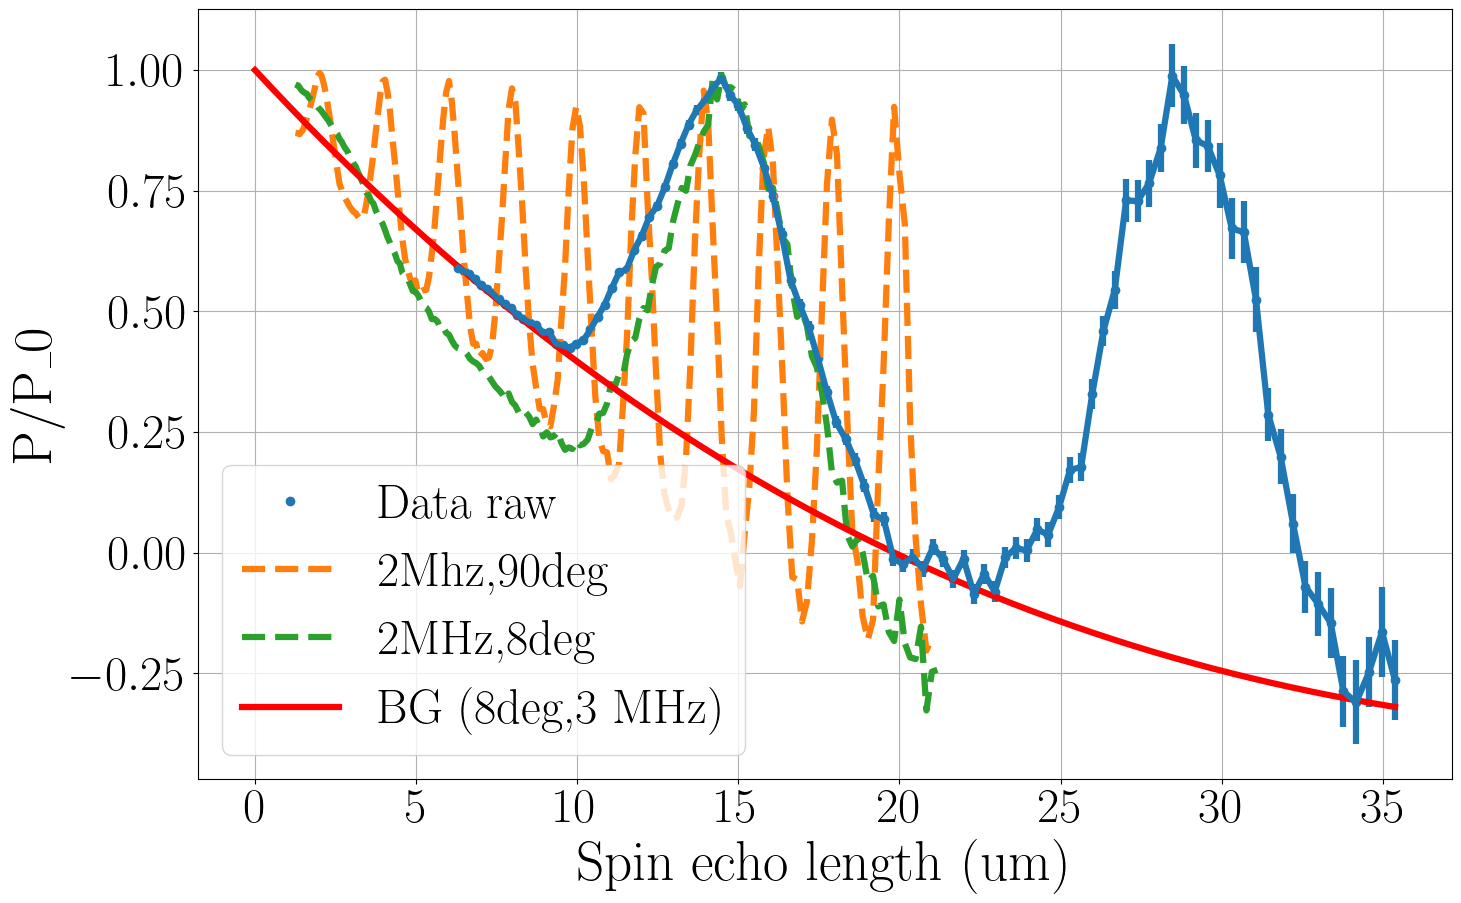

Fitted peak 0: [amp,av,sig]=[ 0.761 14.635  2.117]
	 Errors 0: [0.00514 0.01644 0.01692]
Fitted peak 1: [amp,av,sig]=[ 1.16  28.856  2.223]
	 Errors 1: [0.01739 0.0385  0.03968]


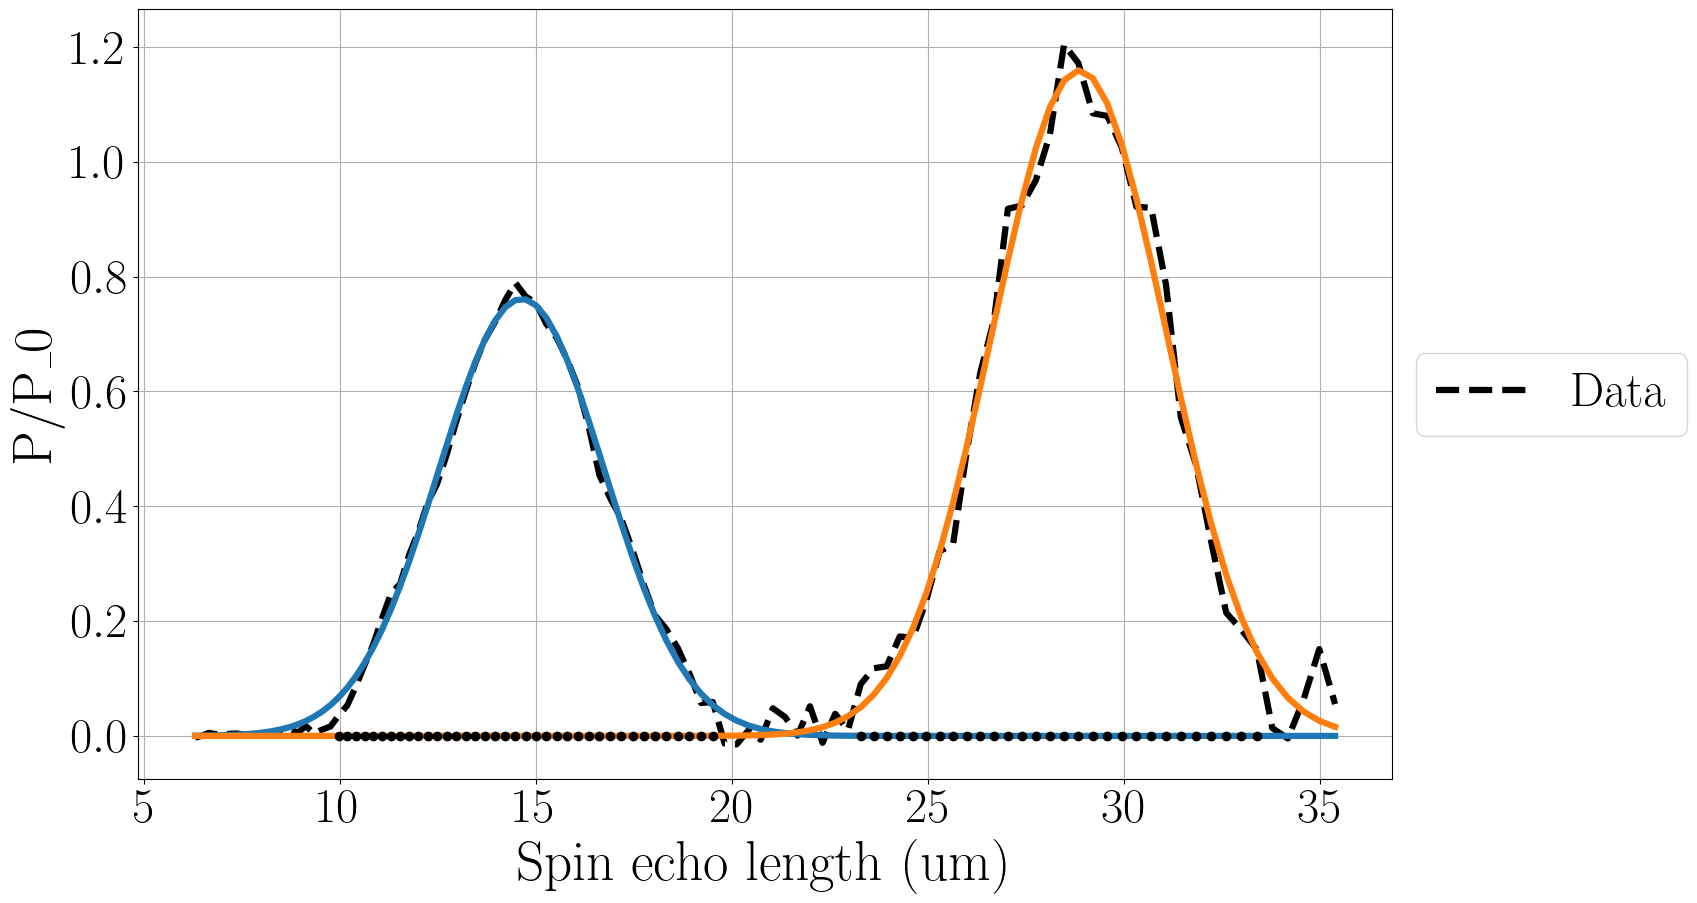

In [5]:
path = home_path
#file = "pols_3Mhz_8deg5.5_0.1_13.25.dat"
file = "pols_3Mhz_8deg5.5_0.075_13.25.dat"
#file = "pols_3Mhz_8deg5.5_0.05_13.25.dat"

with open(path+file) as f:
    temp = f.readlines()[2:-2]
    temp = [l.replace('\n','').split(',') for l in temp]
    x = np.array([float(temp[x][0]) for x in range(len(temp))])/1e3
    x_tot = np.linspace(0,x[-1],400)
    y = np.array([float(temp[y][1]) for y in range(len(temp))])
    e = np.array([float(temp[y][2]) for y in range(len(temp))])

fig, ax = plt.subplots()
plt.plot(x,y,'o',label='Data raw',color='C0')
plt.errorbar(x,y,e,color='C0')
plt.plot(X_saved,Y_saved,'--',label='2Mhz,90deg',color='C1')
plt.plot(X2_saved,Y2_saved,'--',label='2MHz,8deg',color='C2')

bs = [0.69,BG_parms_2_90[1]*np.sqrt(2/3)]  #total guess for the fit
plt.plot(x_tot,BG(x_tot,*bs),color='red',label='BG (8deg,3 MHz)')
print(f'New BG function: {np.round(bs,5)}')

plt.xlabel('Spin echo length (um)')
plt.ylabel('P/P_0')
plt.grid()
ax.legend()#, bbox_to_anchor=(1, 0.5))
plt.show()

fig, ax = plt.subplots()
subtracted = y-BG(x,*bs)
peak_x = np.where(subtracted>0.025)
plt.plot(x,subtracted,'--',color='black',label='Data')

seperated = splitter(peak_x[0],1)

fparms = []
for indx,sep in enumerate(seperated):
    plt.plot(x[sep],np.zeros(len(sep)),'o',color='black',zorder=10)  #peak fit domain
    
    guess = [.5,x[sep[len(sep)//2]],3]
    ff,errs = curve_fit(ampgauss,x[sep],subtracted[sep],p0=guess)
    fparms.append(ff)
    #plt.plot(x,ampgauss(x,*guess),'--',color=f'C{indx}')
    plt.plot(x,ampgauss(x,*ff),color=f'C{indx}')
    print(f'Fitted peak {indx}: [amp,av,sig]={np.round(ff,3)}')
    print(f'\t Errors {indx}: {np.round(np.sqrt(np.diag(errs)),5)}')
fparms = np.array(fparms)

plt.xlabel('Spin echo length (um)')
plt.ylabel('P/P_0')
plt.grid()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

X3_saved = np.copy(x)
X3_tot_saved = np.copy(x_tot)
fparms3_saved = np.copy(fparms)
BG_parms_3_8 = np.copy(bs)
Y3_saved = np.copy(y)
E3_saved = np.copy(e)

***
# 4.5 deg at 3 MHz
***

a = 2163 A^-1 at rf freq 3 MHz
Cosine freq 0.46512 um^(-1/2) 



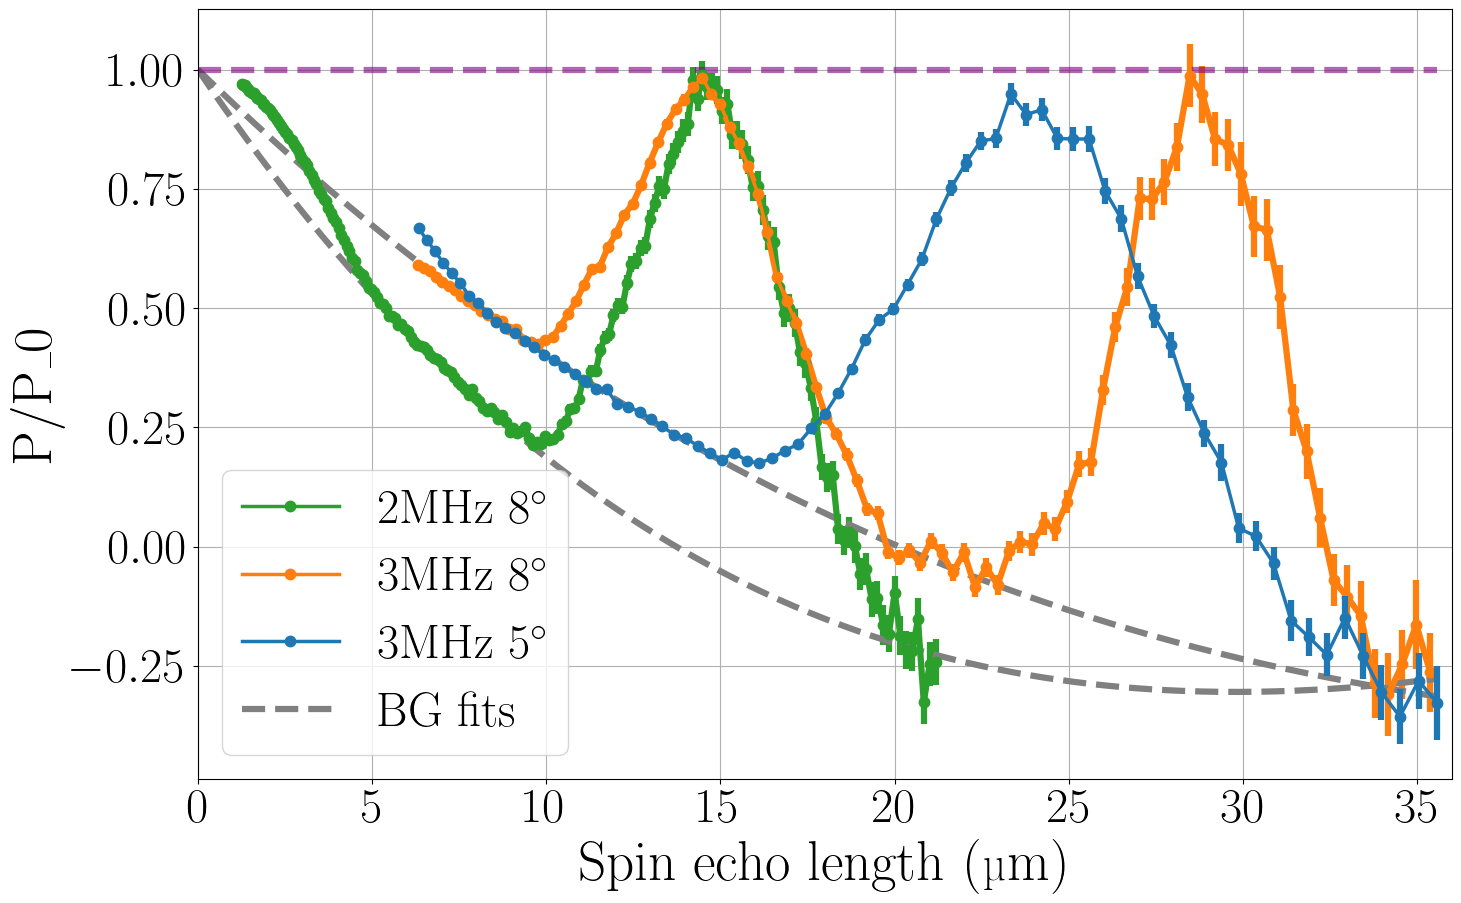

Fitted peak 0: [amp,av,sig]=[0.141 4.444 1.708]
	 Errors 0: [0.04226 0.74886 0.26754]
Fitted peak 1: [amp,av,sig]=[ 1.04  24.267  3.589]
	 Errors 1: [0.00882 0.0351  0.03535]


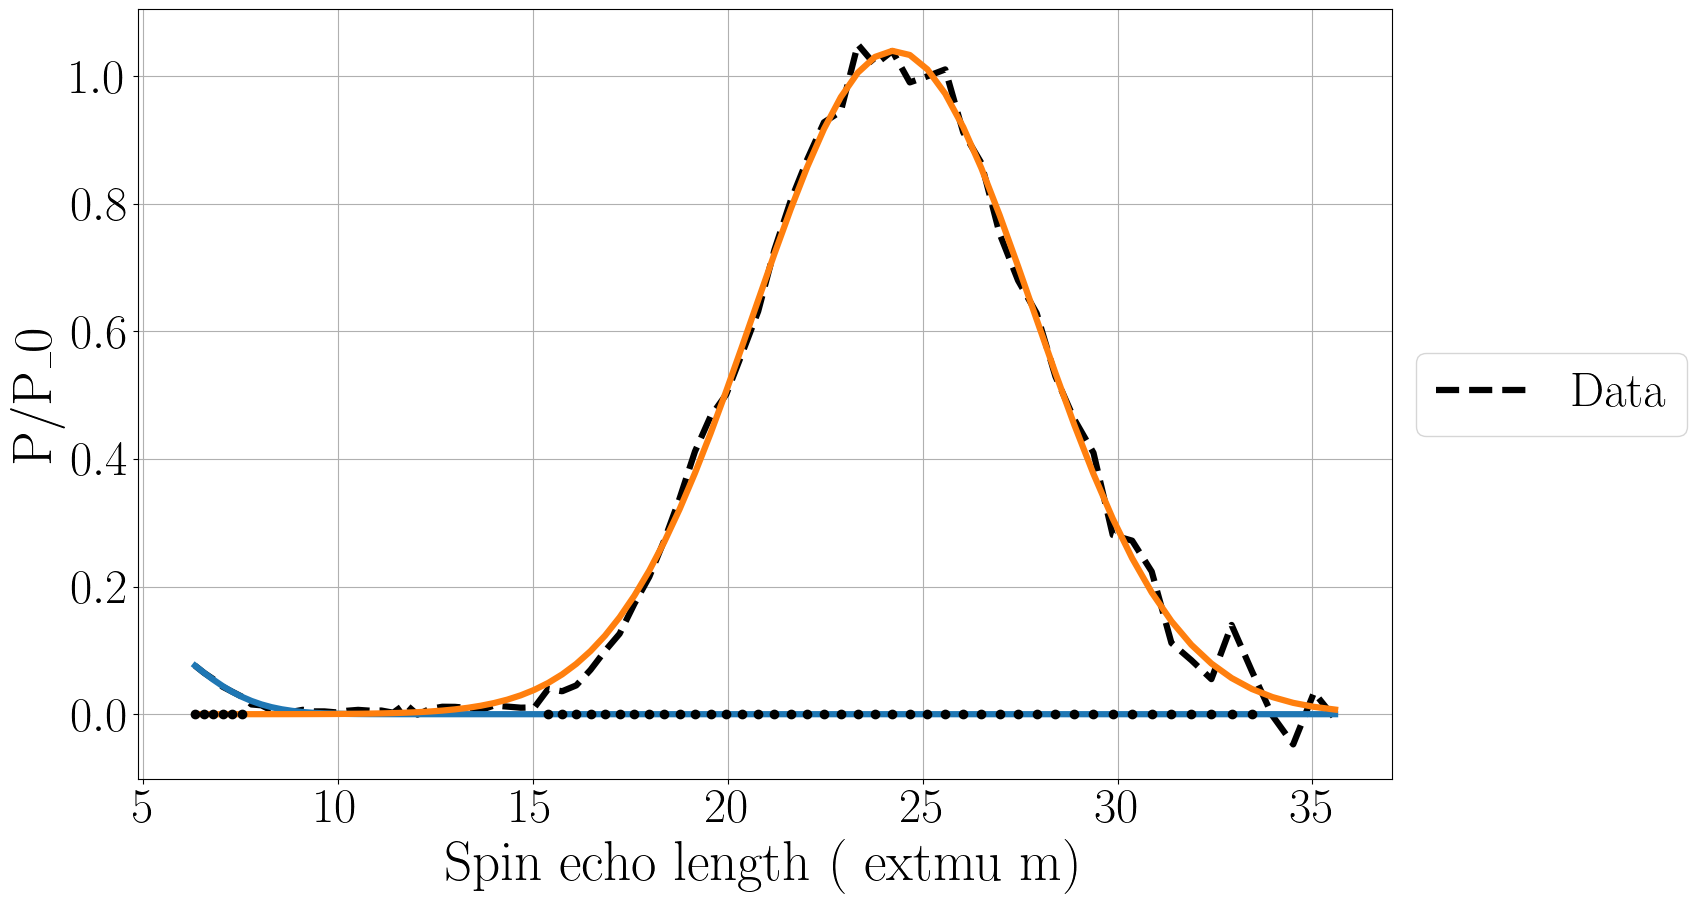

In [17]:
path = home_path
file = "pols_3Mhz_4p5deg5.5_0.1_13.25.dat"

with open(path+file) as f:
    temp = f.readlines()[2:-1]
    temp = [l.replace('\n','').split(',') for l in temp]
    x = np.array([float(temp[x][0]) for x in range(len(temp))])/1e3
    x_tot = np.linspace(0,x[-1],400)

    y = np.array([float(temp[y][1]) for y in range(len(temp))])
    e = np.array([float(temp[y][2]) for y in range(len(temp))])

fig, ax = plt.subplots()
plt.plot(X2_saved,Y2_saved,'o',label='2MHz 8$^{\circ}$',color='C2',ms=7.5,zorder=5,ls='-',linewidth=2.5)
plt.errorbar(X2_saved,Y2_saved,E2_saved,color='C2')
plt.plot(X3_saved,Y3_saved,'o',label='3MHz 8$^{\circ}$',color='C1',ms=7.5,zorder=5,ls='-',linewidth=2.5)
plt.errorbar(X3_saved,Y3_saved,E3_saved,color='C1')

plt.plot(x,y,'o',label='3MHz 5$^{\circ}$',color='C0',ms=7.5,zorder=5,ls='-',linewidth=2.5)
plt.errorbar(x,y,e,color='C0',ls='none',zorder=5)

bg_sec = np.where((8<x) & (x<14))[0]
bg_guess = [.65,get_BG_freq(3,40)[1]]
bg_p,_ = curve_fit(BG,x[bg_sec],y[bg_sec],p0=bg_guess,sigma=e[bg_sec])
#plt.plot(x[bg_sec],y[bg_sec],'o',color='black',ms=15)

plt.plot(x_tot,BG(x_tot,*bg_p),'--',color='gray',label='BG fits')
plt.plot(x_tot,BG(x_tot,*BG_parms_2_8),'--',color='gray')#,label='BG fit 2')
#plt.plot(x_tot,BG(x_tot,BG_parms_2_90[0],np.sqrt(2/3)*parms_tr[1]),'--',color='black',label='BG fit scaled')
#plt.plot(x_tot,BG(x_tot,*BG_parms_3_90),'--',color='green',label='BG (90$^{\circ}$)')

plt.plot(x_tot,np.ones(len(x_tot)),'--',color='purple',alpha=.6)

plt.xlabel(r'Spin echo length (\textmu m)')
plt.ylabel('P/P_0')
plt.grid()
plt.xlim(0,36)
#ax.set_xticks(range(8,36,2))
ax.legend(loc='lower left')#, bbox_to_anchor=(1, 0.5))
plt.show()

fig, ax = plt.subplots()
subtracted = y-BG(x,*bs)
peak_x = np.where(subtracted>0.025)
plt.plot(x,subtracted,'--',color='black',label='Data')

seperated = splitter(peak_x[0],1)

fparms = []
for indx,sep in enumerate(seperated):
    plt.plot(x[sep],np.zeros(len(sep)),'o',color='black',zorder=10)  #peak fit domain
    
    guess = [1,x[sep[indx]],3.6]
    ff,errs = curve_fit(ampgauss,x[sep],subtracted[sep],p0=guess)
    fparms.append(ff)
    #plt.plot(x,ampgauss(x,*guess),'--',color=f'C{indx}')
    plt.plot(x,ampgauss(x,*ff),color=f'C{indx}')
    print(f'Fitted peak {indx}: [amp,av,sig]={np.round(ff,3)}')
    print(f'\t Errors {indx}: {np.round(np.sqrt(np.diag(errs)),5)}')
fparms = np.array(fparms)

plt.xlabel('Spin echo length (\textmu m)')
plt.ylabel('P/P_0')
plt.grid()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

X4_saved = np.copy(x)
X4_tot_saved = np.copy(x_tot)
fparms4_saved = np.copy(fparms)
BG_parms_3_4p5 = np.copy(bg_p)

***
# 90 deg at 3 MHz
***

a = 2163 A^-1 at rf freq 3 MHz
Cosine freq 0.46512 um^(-1/2) 



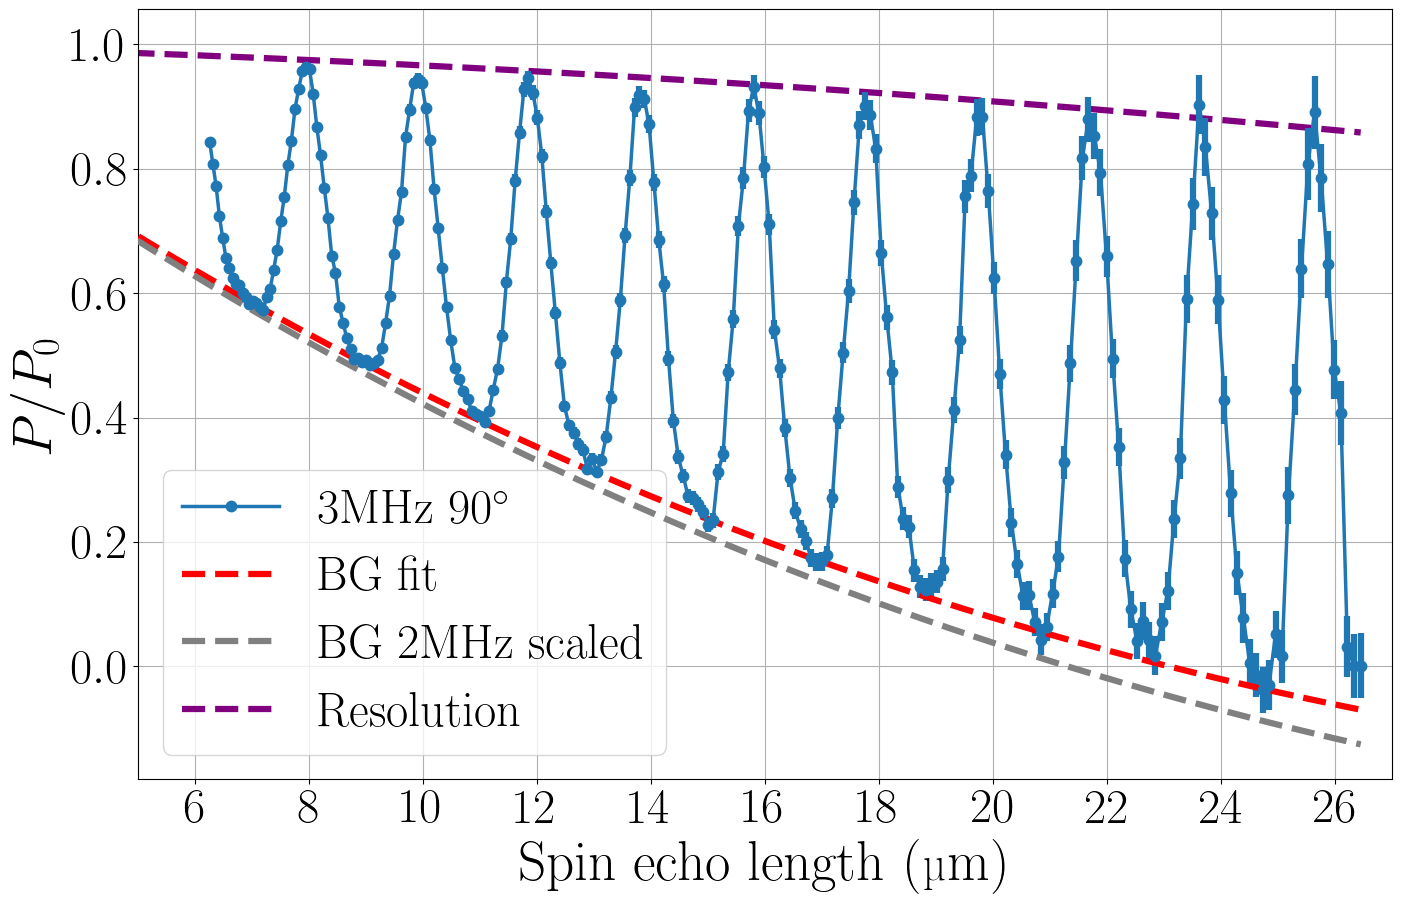

BG fit: 1 + amp*(cos(sqrt(freq)) - 1), [amp,freq]=[0.61046 0.47097]
	 Errs: [0.01257 0.00634]
Peak fit: 1-a*x**2-b*x: [a,b]=[0.00001 0.00494]
	 Errs: [0.00004 0.00065]
--------------------------------------------------

42
Fitted peak 0: [amp,av,sig]=[0.453 7.947 0.335]
	 Errors: [0.00341 0.00292 0.00325]
Fitted peak 1: [amp,av,sig]=[0.536 9.924 0.343]
	 Errors: [0.00596 0.0044  0.00464]
Fitted peak 2: [amp,av,sig]=[ 0.62  11.882  0.342]
	 Errors: [0.00854 0.00544 0.00568]
Fitted peak 3: [amp,av,sig]=[ 0.687 13.848  0.339]
	 Errors: [0.0073  0.00415 0.00441]
Fitted peak 4: [amp,av,sig]=[ 0.748 15.818  0.344]
	 Errors: [0.0143  0.0076  0.00793]
Fitted peak 5: [amp,av,sig]=[ 0.806 17.788  0.356]
	 Errors: [0.01542 0.00789 0.00843]
Fitted peak 6: [amp,av,sig]=[ 0.845 19.748  0.346]
	 Errors: [0.01795 0.00847 0.00855]
Fitted peak 7: [amp,av,sig]=[ 0.909 21.735  0.352]
	 Errors: [0.01845 0.00824 0.00849]
Fitted peak 8: [amp,av,sig]=[ 0.922 23.688  0.35 ]
	 Errors: [0.02142 0.00937 0.00957]


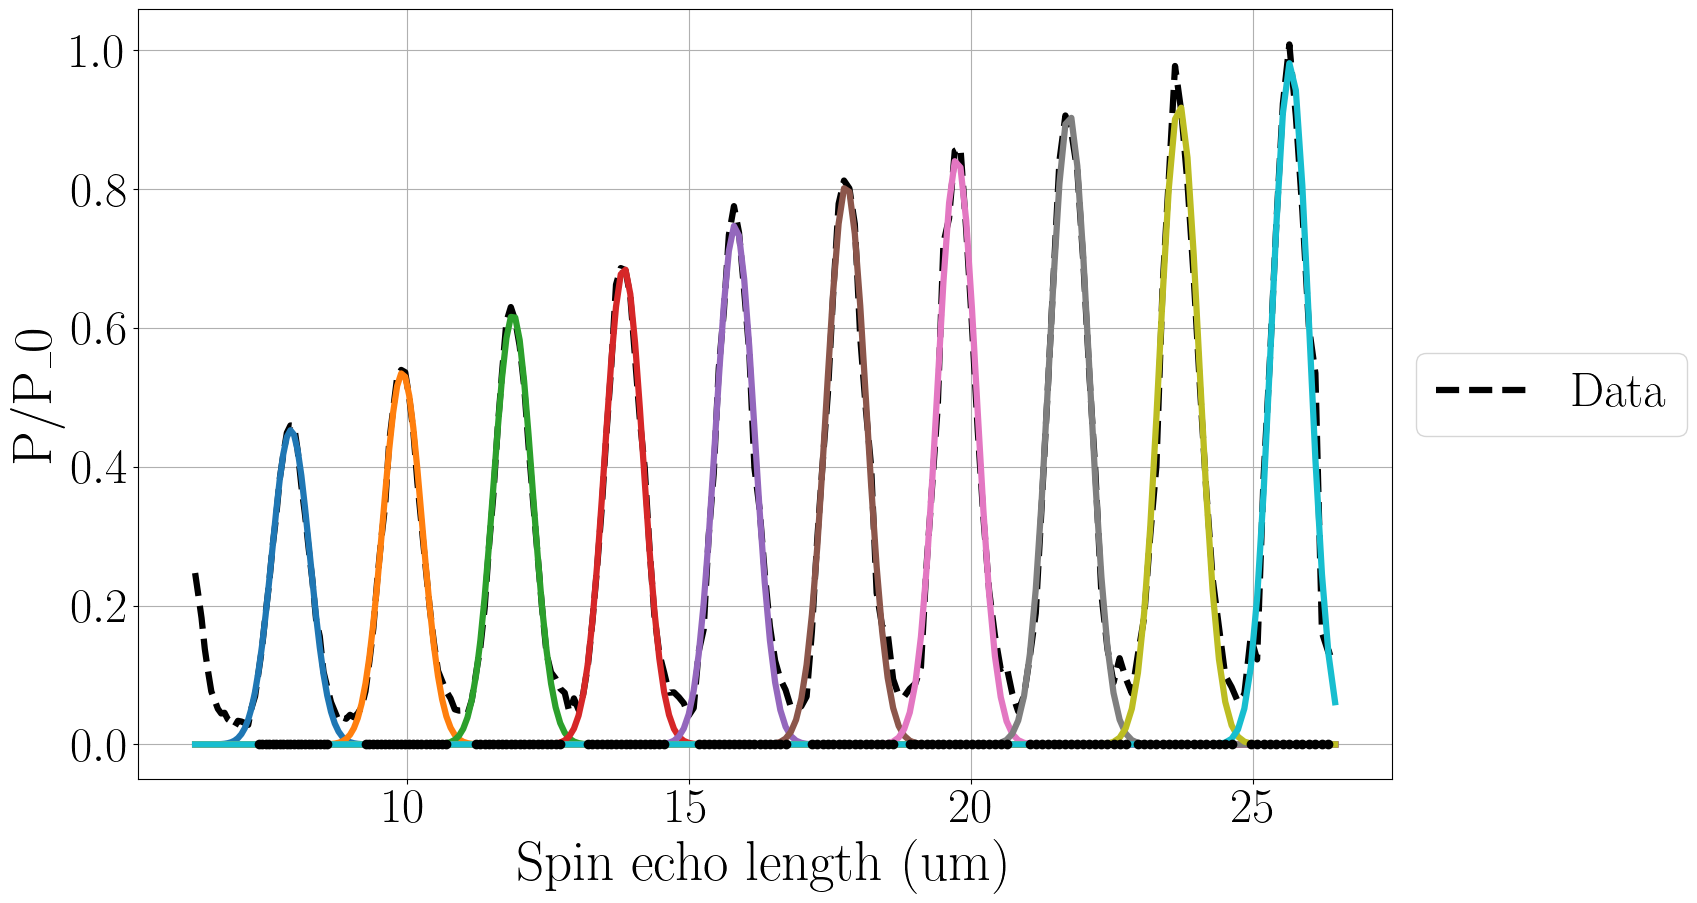

In [7]:
path = home_path
#file = "pols_3Mhz_90deg5.5_0.1_13.25.dat"
#file = "pols_3Mhz_90deg5.5_0.05_13.25.dat" #last peak at -29
file = "pols_3Mhz_90deg5.5_0.025_13.25.dat"

with open(path+file) as f:
    temp = f.readlines()[2:-76]  #-58 to include last peak, -76 otherwise
    temp = [l.replace('\n','').split(',') for l in temp]
    x = np.array([float(temp[x][0]) for x in range(len(temp))])/1e3
    x_tot = np.linspace(0,x[-1],400)
    y = np.array([float(temp[y][1]) for y in range(len(temp))])
    e = np.array([float(temp[y][2]) for y in range(len(temp))])
    
    tr2,_ = find_peaks(-y,prominence=.1)
    #tr2 = np.insert(tr2,[0],[0]) #insert first point: P(0)=1
    pk2,_ = find_peaks(y,prominence=.1)

fig, ax = plt.subplots()
plt.plot(x,y,'o',label='3MHz 90$^{\circ}$',color='C0',ms=7.5,zorder=7,ls='-',linewidth=2.5)
plt.errorbar(x,y,e,color='C0',ls='none',zorder=5)
#plt.plot(x[tr2],y[tr2],'o',ms=10,color='red',zorder=5)
#plt.plot(x[pk2],y[pk2],'o',ms=10,color='green',zorder=5)

guess_tr2 = [.65,get_BG_freq(3,40)[1]]  #sqrt spin echo length cosine
lb = [0,0]
ub = [1,1]
parms_tr2,err_tr2 = curve_fit(BG,x[tr2],y[tr2],p0=guess_tr2,bounds=(lb,ub),sigma=e[tr2])

guess_pk2 = [0,0]  #quad fit
parms_pk2,err_pk2 = curve_fit(quad,x[pk2],y[pk2],sigma=e[pk2])

plt.plot(x_tot,BG(x_tot,*parms_tr2),'--',color='red',label='BG fit',zorder=6)
#plt.plot(x_tot,quad(x_tot,*parms_pk2),'--',color='green',label='Peak fit')
#plt.plot(x_tot,BG(x_tot,*BG_parms_3_8),'--',color='cyan',label='Old BG (8deg,3MHz)')
plt.plot(x_tot,BG(x_tot,BG_parms_2_90[0],np.sqrt(2/3)*BG_parms_2_90[1]),'--',color='gray',label='BG 2MHz scaled',zorder=6)
#plt.plot(x_tot,BG(x_tot,*[.64,Rob_3]),'--',color='green',label='BG')
plt.plot(x_tot,np.ones(len(x_tot))-0.00218*x_tot-0.00012*x_tot**2,'--',color='purple',label='Resolution')

temp = ax.legend(loc='lower left')#, bbox_to_anchor=(1, 0.5))
#temp.set_zorder(3)
plt.xlabel(r'Spin echo length (\textmu m)')
plt.ylabel(r'$P/P_0$')
plt.xlim(5,27)
ax.set_xticks(range(6,28,2))
plt.grid()
plt.show()

print(f'BG fit: 1 + amp*(cos(sqrt(freq)) - 1), [amp,freq]={np.round(parms_tr2,5)}')
print(f'\t Errs: {np.round(np.sqrt(np.diag(err_tr2)),5)}')
print(f'Peak fit: 1-a*x**2-b*x: [a,b]={np.round(parms_pk2,5)}')
print(f'\t Errs: {np.round(np.sqrt(np.diag(err_pk2)),5)}')
print('-'*50 + '\n')

fig, ax = plt.subplots()
#subtracted = y-BG(x,*parms_tr2)
#subtracted = y - BG(x,BG_parms_2_90[0],np.sqrt(2/3)*parms_tr[1])
#subtracted = y-BG(x,*BG_parms_3_8)
subtracted = y-BG(x,*[.64,Rob_3])

peak_x = np.where(subtracted>0.075)
plt.plot(x,subtracted,'--',color='black',label='Data')

seperated = splitter(peak_x[0],1)[1:]

fparms = []
all_errs2 = []
print(len(sep))

for indx,sep in enumerate(seperated):
    plt.plot(x[sep],np.zeros(len(sep)),'o',color='black',zorder=10)  #peak fit domain
    
    guess = [.5,x[sep[len(sep)//2]],.35]
    ff,errs = curve_fit(ampgauss,x[sep],subtracted[sep],p0=guess)
    fparms.append(ff)
    all_errs2.append(errs)
    #plt.plot(x,ampgauss(x,*guess),'--',color=f'C{indx}')
    plt.plot(x,ampgauss(x,*ff),color=f'C{indx}')
    
    print(f'Fitted peak {indx}: [amp,av,sig]={np.round(ff,3)}')
    print(f'\t Errors: {np.round(np.sqrt(np.diag(errs)),5)}')

plt.xlabel('Spin echo length (um)')
plt.ylabel('P/P_0')
plt.grid()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

X5_saved = np.copy(x)
X5_tot_saved = np.copy(x_tot)
fparms5_saved = np.copy(fparms)
BG_parms_3_90 = np.copy(parms_tr2)

***
# Peak width comparison
***

In [ ]:
peak_pos = fparms_saved[:,1]
peak_sig = fparms_saved[:,2]
peak_pos2 = fparms2_saved[:,1]
peak_sig2 = fparms2_saved[:,2]
peak_pos3 = fparms3_saved[:,1]
peak_sig3 = fparms3_saved[:,2]
peak_pos4 = fparms4_saved[:,1]
peak_sig4 = fparms4_saved[:,2]
peak_pos5 = fparms5_saved[:,1]
peak_sig5 = fparms5_saved[:,2]

fig, ax = plt.subplots(figsize=(10,6))
all_poses = np.concatenate((peak_pos,peak_pos5))
all_sigs = np.concatenate((peak_sig,peak_sig5))

really_all_errs = np.concatenate((np.array([np.sqrt(np.diag(e)) for e in all_errs])[:,2],\
                                  np.array([np.sqrt(np.diag(e)) for e in all_errs2])[:,2]))
all_poses, all_sigs, really_all_errs = zip(*sorted(zip(all_poses, all_sigs, really_all_errs)))
all_poses, all_sigs, really_all_errs = np.array(all_poses), np.array(all_sigs), np.array(really_all_errs)

spread1,spread1_err = curve_fit(line,peak_pos,peak_sig,sigma=\
                                np.array([np.sqrt(np.diag(e)) for e in all_errs])[:,2])  #only 2 MHz data
print(f'Slope,intercept of peak standard deviations (2MHz): {np.round(spread1,5)}')
print(f'\t Errors (2MHz): {np.round(np.sqrt(np.diag(spread1_err)),5)}')

spread2,spread2_err = curve_fit(line,peak_pos5,peak_sig5,sigma=\
                                np.array([np.sqrt(np.diag(e)) for e in all_errs2])[:,2])  #only 2 MHz data
print(f'Slope,intercept of peak standard deviations (3MHz): {np.round(spread2,5)}')
print(f'\t Errors (3MHz): {np.round(np.sqrt(np.diag(spread2_err)),5)}')

spread,spread_err = curve_fit(line,all_poses,all_sigs,sigma=really_all_errs)  #both 2 and 3 MHz
print(f'Slope,intercept of peak standard deviations (2MHz and 3MHz): {np.round(spread,5)}')
print(f'\t Errors (2MHz and 3MHz): {np.round(np.sqrt(np.diag(spread_err)),5)}')

zero_se_sig = spread[1]  #zero spin echo width from linear fit
zero_se_sig_saved = zero_se_sig

#qspread1,qspread1_err = curve_fit(mod_quad,peak_pos,peak_sig)
#print(f'ax^2+bx+c of peak standard deviations: {np.round(qspread1,5)}')
#print(f'\t Errors: {np.round(np.sqrt(np.diag(qspread1_err)),5)}')

plt.plot(peak_pos,peak_sig,'o',label='2MHz',color='C0')
plt.errorbar(peak_pos,peak_sig,np.array([np.sqrt(np.diag(e)) for e in all_errs])[:,2],color='C0',ls='none')
plt.plot(peak_pos5,peak_sig5,'o',label='3MHz',color='C1')
plt.errorbar(peak_pos5,peak_sig5,np.array([np.sqrt(np.diag(e)) for e in all_errs2])[:,2],color='C1',ls='none')

#plt.axhline(y=1.44/np.sqrt(24),color='black',label='Ideal')
plt.plot(peak_pos,line(peak_pos,*spread1),'-',color='C0')
plt.plot(peak_pos5,line(peak_pos5,*spread2),'-',color='C1')
plt.plot(all_poses,line(all_poses,*spread),'--',label='Total Fit',color='C2')
#plt.plot(peak_pos,mod_quad(peak_pos,*qspread1),'--',label='Quad fit',color='C3')

plt.xlim([-.5, 28.5])
plt.xlabel('Spin echo length (um)')
plt.ylabel('Peak stnd (um)')
ax.set_xticks([0.,5.,10.,15.,20.,25.])
plt.grid()
plt.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

if False:
    print(f'{"-"*10}2 MHz 90 deg{"-"*10} \n {np.round(fparms_saved,5)}')
    print(f'{"-"*10}2 MHz 8 deg{"-"*10} \n {np.round(fparms2_saved,5)}')
    print(f'{"-"*10}3 MHz 8 deg{"-"*10} \n {np.round(fparms3_saved,5)}')
    print(f'{"-"*10}3 MHz 4.5 deg{"-"*10} \n {np.round(fparms4_saved,5)}')
    print(f'{"-"*10}3 MHz 90 deg{"-"*10} \n {np.round(fparms5_saved,5)} \n')

if False:
    print(f'Width comparison factors using effective zero spin echo length peak width:')
    print(f'\t 2 MHz at 8 deg: {round(peak_sig2[1]/zero_se_sig,5)}')
    print(f'\t 3 MHz at 8 deg: {np.round(peak_sig3/zero_se_sig,5)}')
    print(f'\t 3 MHz at 4.5 deg: {round(peak_sig4[1]/zero_se_sig,5)}')
    print(f'\t 3 MHz at 90 deg: {np.round(peak_sig5/zero_se_sig,5)} \n')

if False:
    print(f'Peak position increase factors using fitted 1st peak position at 2 MHz, 90 deg:')
    print(f'\t 2 MHz at 8 deg: {round(peak_pos2[1]/peak_pos[0],5)}')
    print(f'\t 3 MHz at 8 deg: {np.round(peak_pos3/peak_pos[0],5)}')
    print(f'\t 3 MHz at 4.5 deg: {round(peak_pos4[1]/peak_pos[0],5)}')
    print(f'\t 3 MHz at 90 deg: {np.round(peak_pos5/peak_pos[3],5)} \n') #compare same order

if False:
    print(f'Ratios (width/position):')
    print(f'\t 2 MHz at 8 deg: {round(peak_sig2[1]/zero_se_sig/(peak_pos2[1]/peak_pos[0]),5)}')
    print(f'\t 3 MHz at 8 deg: {np.round(peak_sig3/zero_se_sig/(peak_pos3[0]/peak_pos[0]),5)}')
    print(f'\t 3 MHz at 4.5 deg: {round(peak_sig4[1]/zero_se_sig/(peak_pos4[1]/peak_pos[0]),5)}')
    print(f'\t 3 MHz at 90 deg: {np.round(peak_sig5/zero_se_sig/(peak_pos5[0]/peak_pos[3]),5)} \n')

Saved:
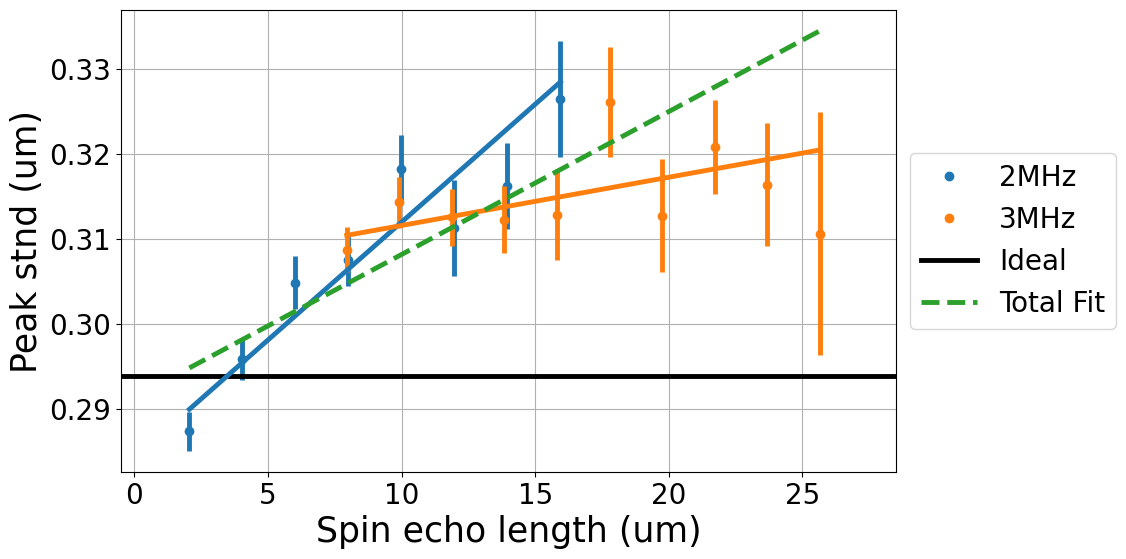

Saved:
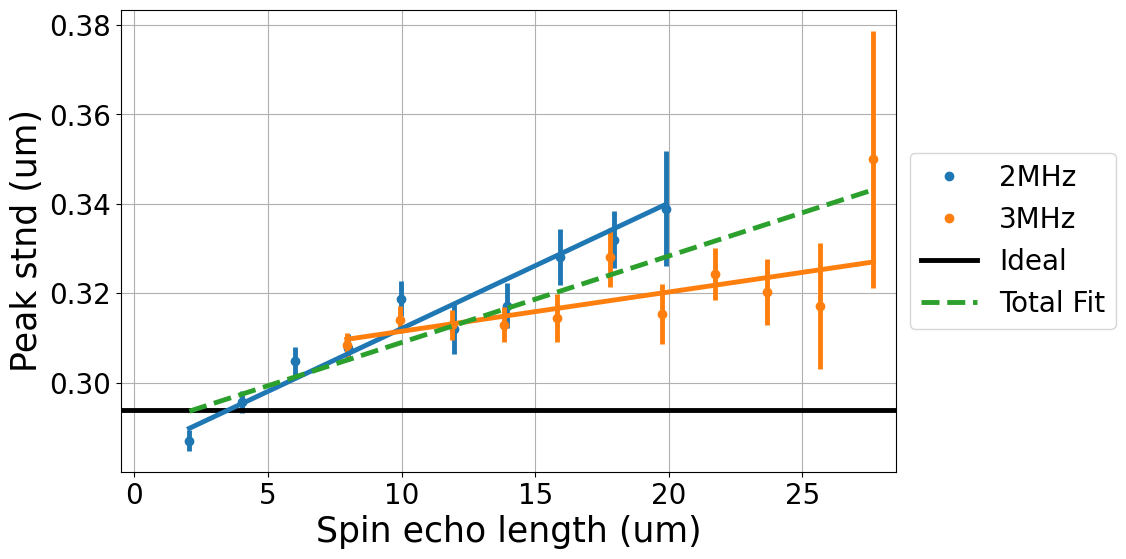

### Excess width

In [ ]:
zero_se_sig = zero_se_sig_saved
zero_se_sig = 1.44/np.sqrt(24)  #standard deviation of triangular distribution
print(f'Zero spin echo stnd (theory): {round(zero_se_sig,5)} \n')
print(f'Zero spin echo stnd (fitted): {round(zero_se_sig_saved,5)} \n')

def sqrt_ex(x,a):
    return a*np.sqrt(x)
def log_ex(x,a):
    return a*np.log(x+1)
def line_ex(x,a):
    return a*x

excess = (peak_sig**2 - zero_se_sig**2)
excess2 = (peak_sig5**2 - zero_se_sig**2)

all_sigs = np.concatenate((peak_sig,peak_sig5))
all_poses = np.concatenate((peak_pos,peak_pos5))
all_excess = np.concatenate((excess,excess2))
print(f'Excesses: {all_excess} \n')

all_poses, all_excess, all_sigs = zip(*sorted(zip(all_poses, all_excess, all_sigs)))
all_poses, all_excess, all_sigs = np.array(all_poses), np.array(all_excess), np.array(all_sigs)

#need to check this formula...
sig_g = 2*np.sqrt([(all_sigs[i]*really_all_errs[i])**2 + \
                 (zero_se_sig*.001)**2 for i in range(len(all_excess))])
print(f'Widths: {sig_g} \n')

plt.plot(all_poses,all_excess,'o',ms=10)
plt.errorbar(all_poses,all_excess,sig_g,ls='None',color='C0')

if False:
    fitted,pcov = curve_fit(sqrt_ex,all_poses,all_excess,sigma=sig_g)
    print(f'Sqrt fit a*sqrt(x): [a] = {np.round(fitted,5)}')
    print(f'\t Errors: {np.round(np.sqrt(np.diag(pcov)),5)}')
    plt.plot(all_poses,sqrt_ex(all_poses,*fitted),'-',label='Sqrt Fit')

if False:
    fitted,pcov = curve_fit(log_ex,all_poses,all_excess,sigma=sig_g)
    print(f'Log fit a*log(x+1): [a] = {np.round(fitted,5)}')
    print(f'\t Errors: {np.round(np.sqrt(np.diag(pcov)),5)}')
    plt.plot(all_poses,log_ex(all_poses,*fitted),'-',label='Log Fit')

if True:
    fitted,pcov = curve_fit(line_ex,all_poses,all_excess,sigma=sig_g)
    print(f'Linear fit a*x: [a] = {np.round(fitted,5)}')
    print(f'\t Errors: {np.round(np.sqrt(np.diag(pcov)),5)}')
    plt.plot(all_poses,line_ex(all_poses,*fitted),'-',label='Linear Fit')
    print(f'Sqrt of slope: {round(np.sqrt(fitted[0]),5)}')

plt.xlabel('Spin echo length (um)')
plt.ylabel('width^2 - zero_width^2 (um^2)')
plt.xlim([0, 30])
ax.set_xticks([0.,5.,10.,15.,20.,25.,30.])
plt.legend()
plt.grid()
plt.show()

***
# Convolution testing
***

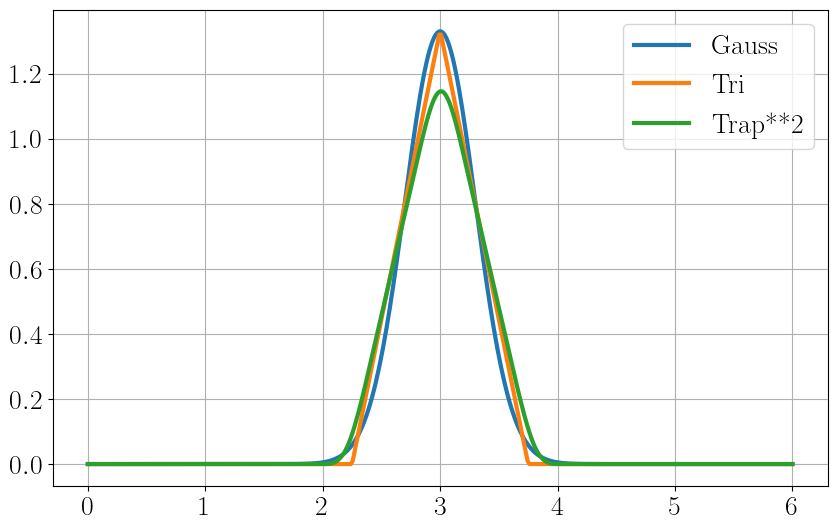

In [37]:
def tri(x,parms):
    if len(parms)==2:
        mn,mx = parms
        md = (mx+mn)/2 #symmetric case
    else:
        mn,md,mx = parms
        
    output = []
    for val in x:
        if val<mn: output.append(0)
        elif val<md:
            temp = 2*(val-mn)/((mx-mn)*(md-mn))
            output.append(temp)
        elif val<mx:
            temp = 2*(mx-val)/((mx-mn)*(mx-md))
            output.append(temp)
        else: output.append(0)
    return output

def sqr(x,parms):
    a,b = parms
    output = []
    for val in x:
        if val<a: output.append(0)
        elif val<b: output.append(1)
        else: output.append(0)
    return output/simpson(output,x)

def trap(x,parms):
    a,b,c,d = parms
    output = []
    for val in x:
        if val<a: output.append(0)
        elif val<b:
            temp = 2/(d+c-a-b)*(val-a)/(b-a)
            output.append(temp)
        elif val<c:
            temp = 2/(d+c-a-b)
            output.append(temp)
        elif val<d:
            temp = 2/(d+c-a-b)*(d-val)/(d-c)
            output.append(temp)
        else: output.append(0)
    return output

x_temp = np.linspace(0,6,400)
gp = [3,.3]
plt.plot(x_temp,gauss(x_temp,*gp),label='Gauss')

trip = [2.25,3,3.75]
plt.plot(x_temp,tri(x_temp,trip),label='Tri')

trapp = [2.5,2.7,3.3,3.5]
c_trap = convolve(trap(x_temp,trapp),trap(x_temp,trapp),mode='same')
c_trap = c_trap/simpson(c_trap,x=x_temp)
plt.plot(x_temp,c_trap,label='Trap**2')

plt.legend()
plt.grid()
plt.show()

****
# Figures
***

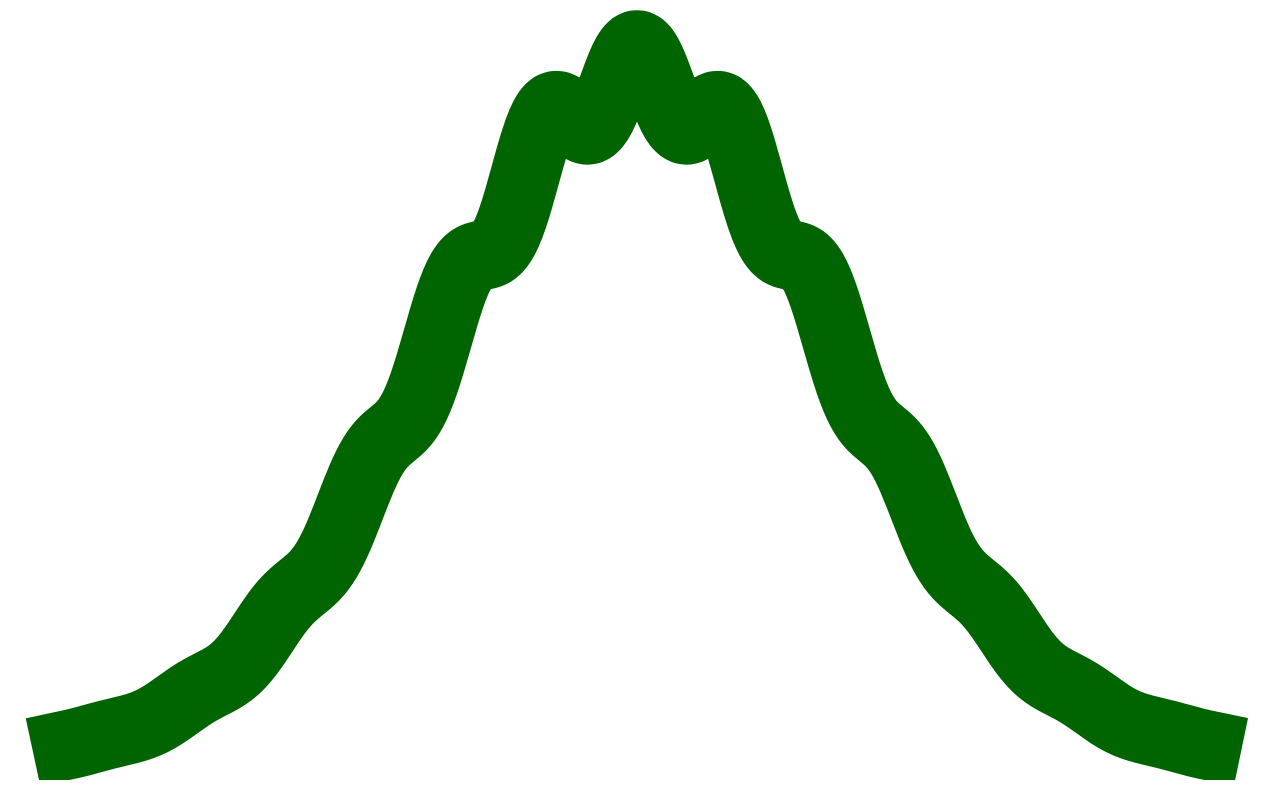

In [124]:
"""plt.plot(np.exp(-np.linspace(-2,2,400)**2),linewidth=50,color='indigo')
plt.axis('off')
plt.savefig('gs_purple.png', transparent=True)

plt.plot(np.exp(-np.linspace(-2,2,400)**2),linewidth=50,color='darkorange')
plt.axis('off')
plt.savefig('gs_orange.png', transparent=True)
plt.plot((1+.1*np.cos(20*np.linspace(-2,2,400)))*np.exp(-np.linspace(-2,2,400)**2),linewidth=40,color='darkorange')
plt.axis('off')
plt.savefig('gs_scatt_orange.png', transparent=True)

plt.plot(np.exp(-np.linspace(-2,2,400)**2),linewidth=50,color='mediumblue')
plt.axis('off')
plt.savefig('gs_blue.png', transparent=True)
plt.plot((1+.1*np.cos(20*np.linspace(-2,2,400)))*np.exp(-np.linspace(-2,2,400)**2),linewidth=40,color='mediumblue')
plt.axis('off')
plt.savefig('gs_scatt_blue.png', transparent=True)
"""
plt.plot((1+.05*np.cos(20*np.linspace(-2,2,400)))*np.exp(-np.linspace(-2,2,400)**2),linewidth=50,color='darkgreen')
plt.axis('off')
plt.savefig('gs_scatt_green.png', transparent=True)

***
# Coherence and the Eikonal Approximation
***

Area of |psi_+|^2 = 0.5
Area of |psi_-|^2 = 0.5
Area of s_x = -1.0
Area of s_y = -0.0
Area of s_z = 0.0
Norm check: 1.0


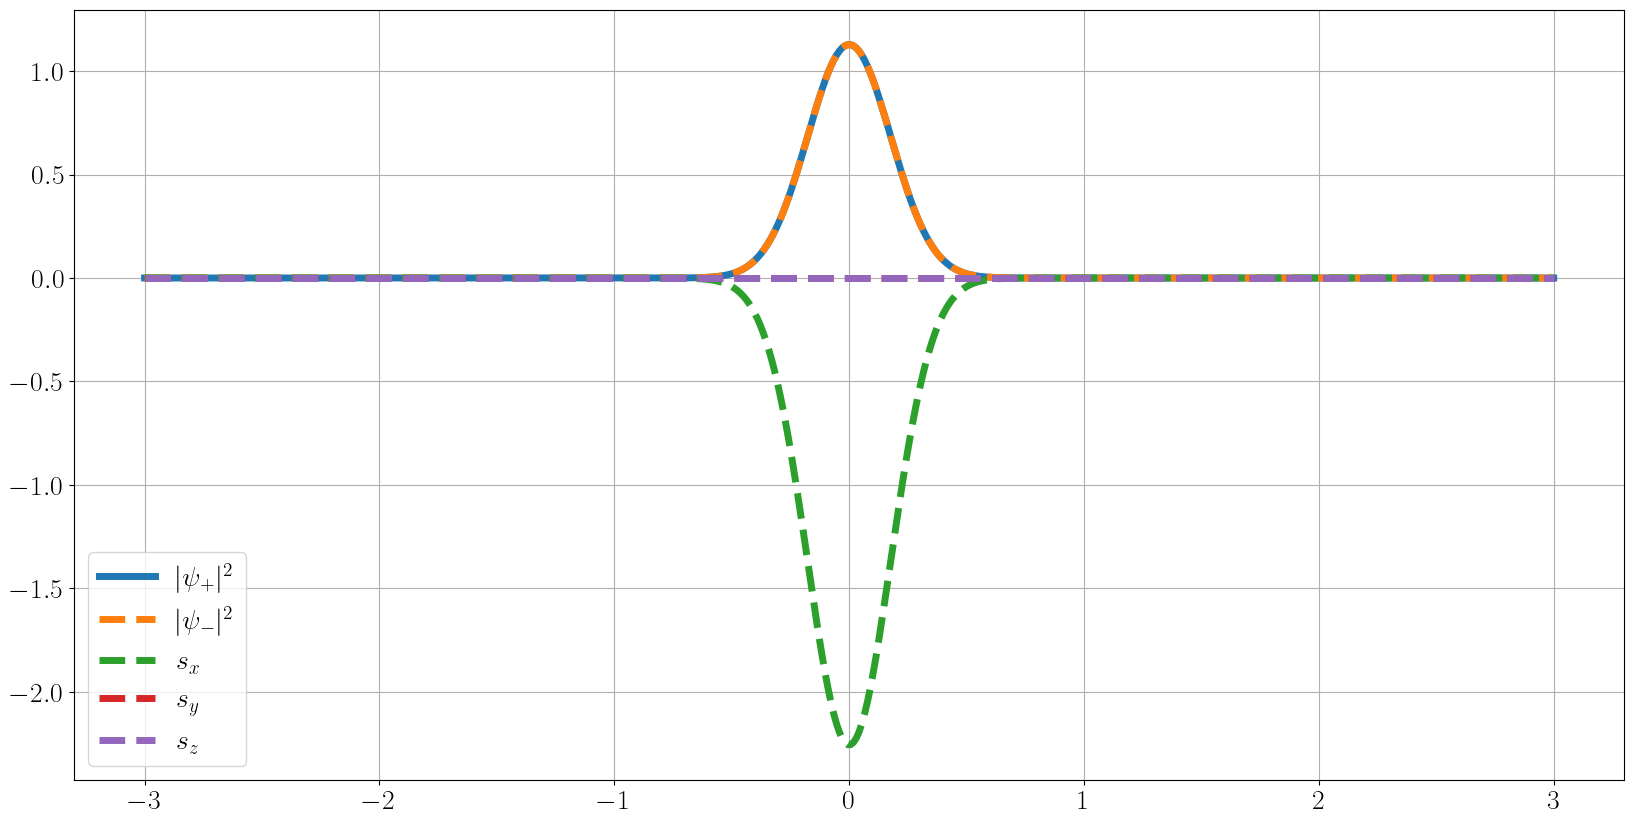

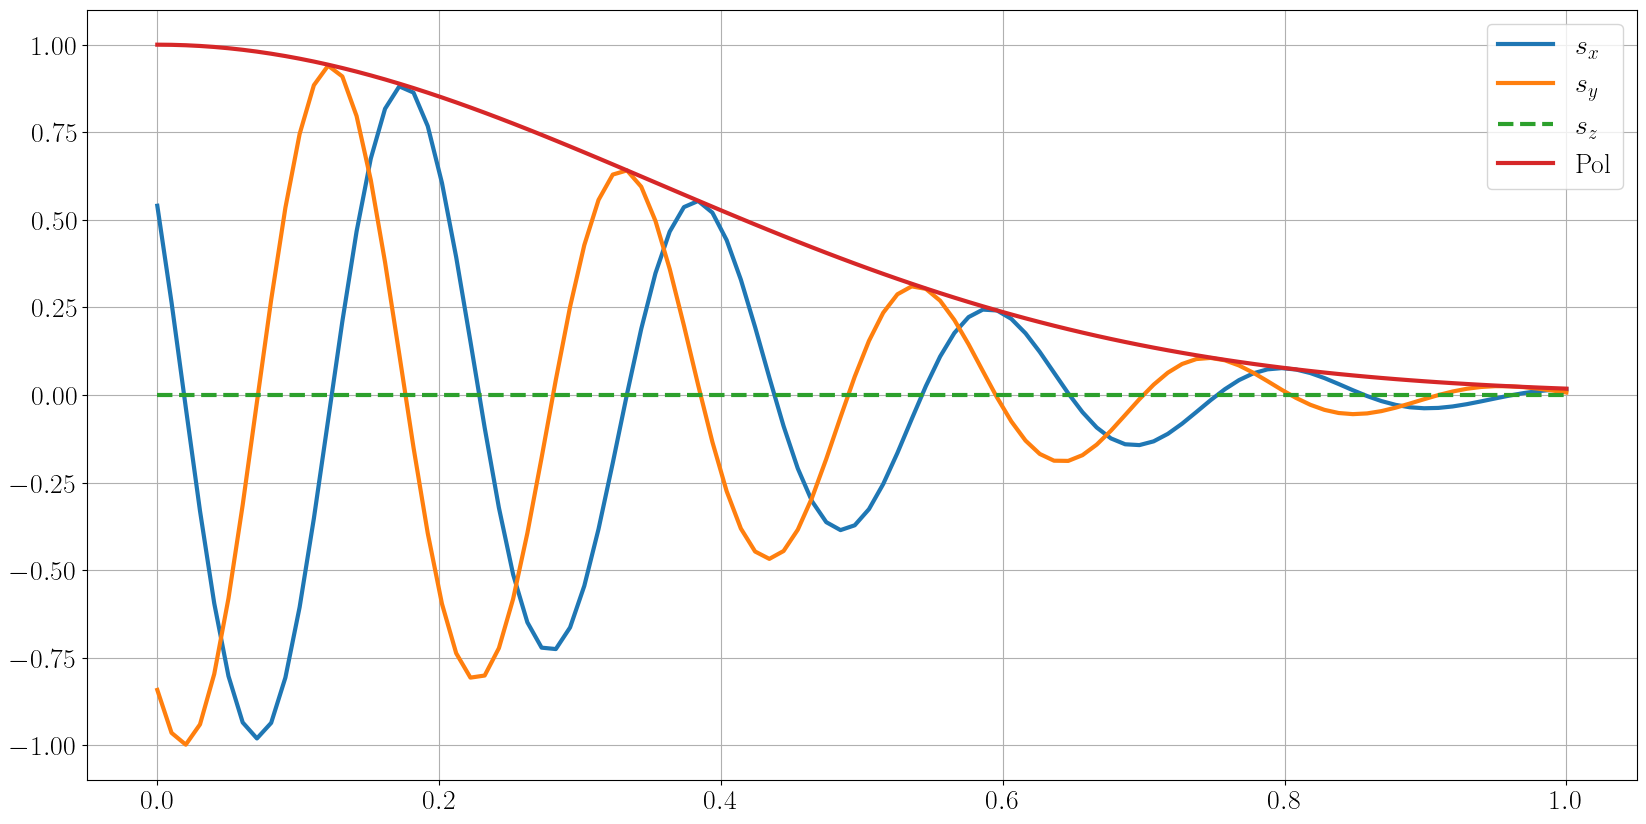

In [191]:
x_space = np.linspace(-3,3,500)

def get_pol(p_phase=0,m_phase=0,p_x=0,m_x=0,p_w=.25,m_w=.25,p_a=1,m_a=1,plot=False):

    psi_p = p_a*np.exp(-(x_space-p_x)**2/(2*p_w**2))*np.exp(1j*p_phase)
    psi_m = m_a*np.exp(-(x_space-m_x)**2/2/m_w**2)*np.exp(-1j*m_phase)
    nor = simpson(np.abs(psi_p)**2 + np.abs(psi_m)**2,x=x_space)
    psi_p = psi_p/np.sqrt(nor)
    psi_m = psi_m/np.sqrt(nor)

    sig_x = 2*np.real(np.conjugate(psi_p)*psi_m)
    sig_y = 2*np.imag(np.conjugate(psi_p)*psi_m)
    sig_z = np.abs(psi_p)**2 - np.abs(psi_m)**2

    a_sx = simpson(sig_x,x=x_space)
    a_sy = simpson(sig_y,x=x_space)
    a_sz = simpson(sig_z,x=x_space)
    
    if plot:
        #print(f'Area of |psi|^2 = {round(simpson(np.abs(psi_p)**2 + np.abs(psi_m)**2,x=x_space),3)}')
        print(f'Area of |psi_+|^2 = {round(simpson(np.abs(psi_p)**2,x=x_space),3)}')
        print(f'Area of |psi_-|^2 = {round(simpson(np.abs(psi_m)**2,x=x_space),3)}')
        print(f'Area of s_x = {round(a_sx,3)}')
        print(f'Area of s_y = {round(a_sy,3)}')
        print(f'Area of s_z = {round(a_sz,3)}')
        print(f'Norm check: {np.round(np.sqrt(a_sx**2 + a_sy**2 + a_sz**2),5)}')
        
        fig, ax = plt.subplots(figsize=(20,10))
        plt.plot(x_space,np.abs(psi_p)**2,linewidth=5,label=r'$|\psi_+|^2$')
        plt.plot(x_space,np.abs(psi_m)**2,'--',linewidth=5,label=r'$|\psi_-|^2$')
        #plt.plot(x_space,np.abs(psi_p)**2 + np.abs(psi_m)**2,linewidth=5,label='|psi|^2')
        plt.plot(x_space,sig_x,'--',linewidth=5,label='$s_x$')
        plt.plot(x_space,sig_y,'--',linewidth=5,label='$s_y$')
        plt.plot(x_space,sig_z,'--',linewidth=5,label='$s_z$')
        plt.grid()
        plt.legend(loc='lower left')
        plt.show()
    return a_sx,a_sy,a_sz

_ = get_pol(plot=True,p_phase=np.pi)

x,y,z = [],[],[]
wp_sep = np.linspace(0,1,100)
for sep in wp_sep:
    temp_x,temp_y,temp_z = get_pol(p_x=sep,p_phase=sep*30+1)
    x.append(temp_x)
    y.append(temp_y)
    z.append(temp_z)
x,y,z = np.array(x),np.array(y),np.array(z)

fig, ax = plt.subplots(figsize=(20,10))
plt.plot(wp_sep,x,label='$s_x$')
plt.plot(wp_sep,y,label='$s_y$')
plt.plot(wp_sep,z,'--',label='$s_z$')
plt.plot(wp_sep,np.sqrt(x**2+y**2+z**2),label='Pol')
plt.grid()
plt.legend(loc='upper right')
plt.show()

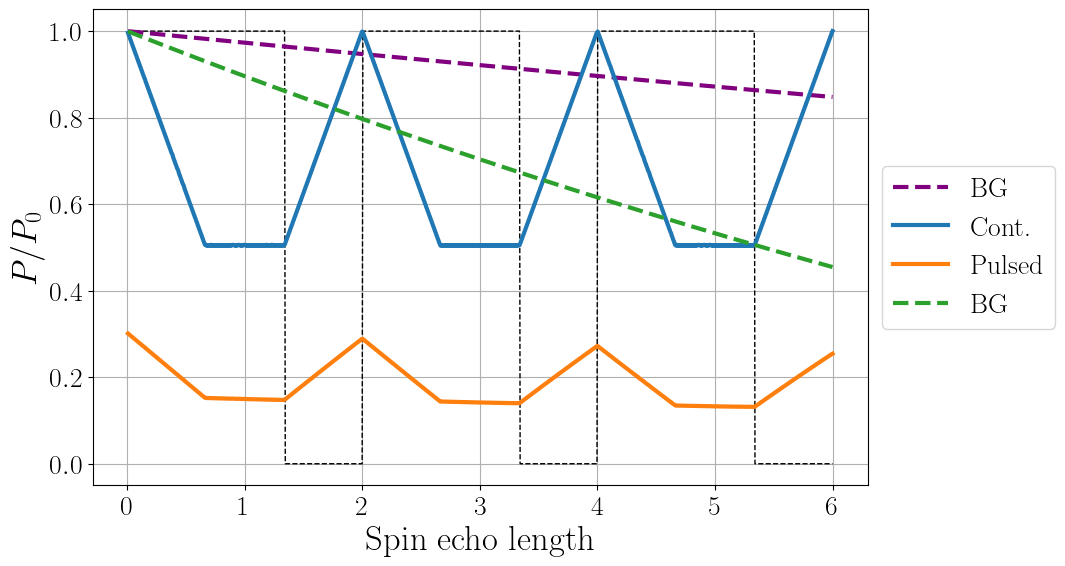

In [71]:
x = np.linspace(6,0,1000,endpoint=False)[::-1]
b0 = 0
height = 1
tc_2,tc_3 = .57,1 #.57,.465
p = 2
m = p - 0.66

def BG_cos(x,m,tc):
    return 1 + (p-m)*(np.cos(np.sqrt(x)*tc) - 1)

def BG(x,tc):
    return (1 - np.cos(tc*np.sqrt(x)))/x*2/tc**2
    
def rect(x,a,b,h,p):
    result = np.zeros(len(x))
    for n in range(0,int((x[-1])//p+1)):
        result = result + np.where((x>a+n*p) & (x<b+n*p),h,0)
    return result

def mod_rect(x,tc,b0,m,p):
    return -1j*rect(x,b0,b0+m,height,p)*(1 - np.exp(-1j*tc*np.sqrt(x)))/np.sqrt(x)

def mod_rect2(x,tc,b0,m,p):
    return -1j*rect(x,b0,b0+m,np.exp(1-1j*tc*np.sqrt(x))/np.sqrt(x),p)

def ACF(x,f,parms,real=True,BG_parms=[]):
    result = []
    for xi in x:
        if not real: 
            f1 = np.conj(f(x,*parms))
        else:
            f1 = f(x,*parms)
        f2 = f(x+xi,*parms)
        if len(BG_parms)>0:
            result.append(simpson(f1*f2,x=x)/BG(xi,*BG_parms))
        else:
            result.append(simpson(f1*f2,x=x))
    return np.real(result)

rect1 = rect(x,b0,b0+m,height,p)  #grating
bagr = BG(x,tc_2)  #Eikonal background

ACF1 = ACF(x,rect,(b0,b0+m,height,p))
ACF1 = ACF1/simpson(rect1,x=x)
ACF2 = ACF(x,mod_rect,(tc_2,b0,b0+m,p),real=False)#,BG_parms=[tc_2])
ACF2 = ACF2/simpson(rect1,x=x)

fig, ax = plt.subplots()
plt.plot(x,rect1,'--',color='black',linewidth=1)
plt.plot(x,bagr,'--',color='purple',label='BG',)
plt.plot(x,ACF1,'-',label='Cont.')
plt.plot(x,ACF2,'-',label='Pulsed')
plt.plot(x,BG_cos(x,m,tc_2),'--',label='BG')
plt.ylabel(r'$P/P_0$')
plt.xlabel('Spin echo length')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.show()

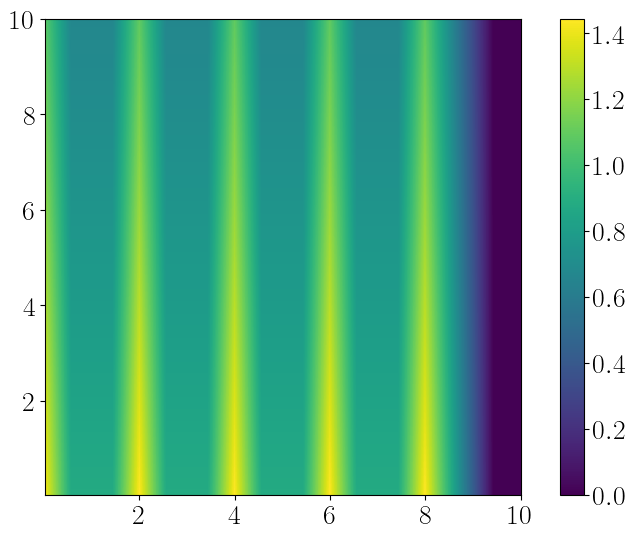

In [72]:
p = 2
w = 1.44
k = .57
xi_space = np.linspace(10,0,300,endpoint=False)[::-1]
t_space = np.linspace(-p/2,p/2,300)

def S(ts,phase):
    result = [phase if (t>-w/2 and t<w/2) or (t>-w/2-p and t<w/2-p) or (t>-w/2+p and t<w/2+p) \
              or (t>-w/2-2*p and t<w/2-2*p) or (t>-w/2+2*p and t<w/2+2*p) \
              or (t>-w/2-3*p and t<w/2-3*p) or (t>-w/2+3*p and t<w/2+3*p) \
              or (t>-w/2-4*p and t<w/2-4*p) or (t>-w/2+4*p and t<w/2+4*p) else 0 for t in ts]
    return np.array(result)

def ACF(f1,f2):
    return np.real(np.conj(f1)*f2)

def P(phase):
    Pol = []
    temp1 = (np.exp(-1j*S(t_space,phase))-1)/phase
    for xi in np.copy(xi_space):
        temp2 = (np.exp(-1j*S(t_space+xi,phase))-1)/phase
        tempACF = ACF(temp1,temp2)
        Pol.append(simpson(tempACF,x=t_space))
    return Pol

Pols = np.array([P(k*np.sqrt(xi)) for xi in xi_space])

plt.imshow(Pols,origin='lower',extent=[xi_space[0],xi_space[-1],xi_space[0],xi_space[-1]])
plt.colorbar()
plt.show()

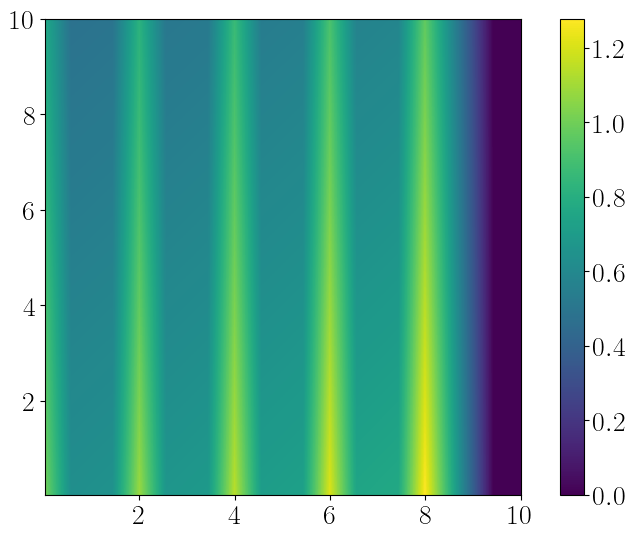

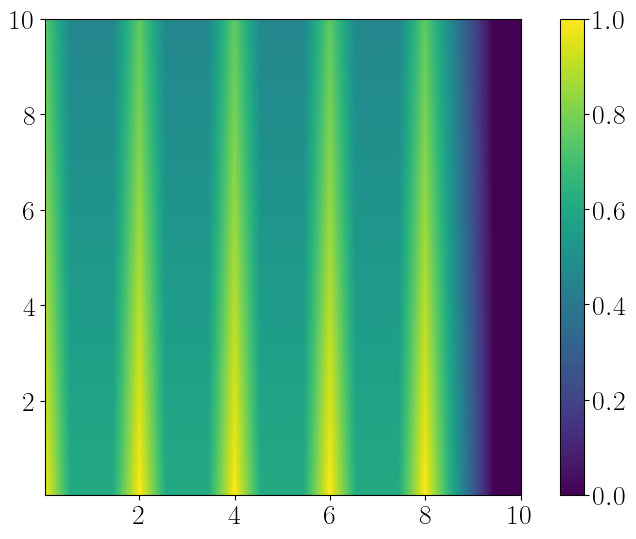

In [73]:
P0 = Pols[:,0]
NP0 = np.array([Pols[i,:]/P0 for i in range(len(xi_space))])
NP0_2 = Pols/np.max(Pols)

plt.imshow(NP0,origin='lower',extent=[xi_space[0],xi_space[-1],xi_space[0],xi_space[-1]])
plt.colorbar()
plt.show()
plt.imshow(NP0_2,origin='lower',extent=[xi_space[0],xi_space[-1],xi_space[0],xi_space[-1]])
plt.colorbar()
plt.show()

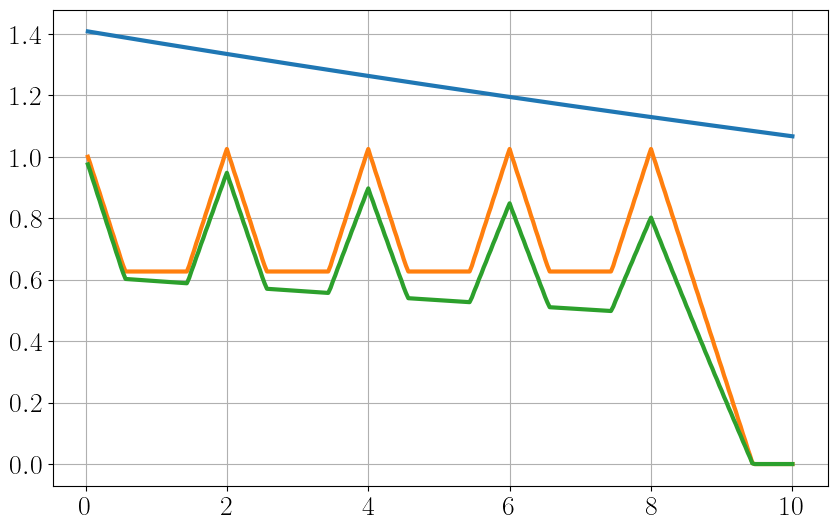

In [74]:
plt.plot(xi_space,P0)
plt.plot(xi_space,np.diag(NP0))
plt.plot(xi_space,np.diag(NP0_2))
plt.grid()
plt.show()